In [ ]:
import collections
from pathlib import Path
import copy
import os
import pandas as pd
import gzip
import shutil
import glob

import dask
import dask.dataframe as dd


from collections import defaultdict
from tqdm import tqdm

import numpy as np
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
#from lightning.pytorch.loggers import TensorBoardLogger   #MOODY DID THIS
from pytorch_lightning import loggers
from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer

import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import folium

In [775]:
# Flight Events (EV)
# Flight Summary (RD)
# Track Points(IFF)

In [776]:
import datetime


def create_folium_map(lat1, long1, lat2, long2, border_lat_prop=0.15, border_long_prop=0.15, tiles=None):
    """
    Create folium map object given min/max coordinate points of desired flightpath

    tiles, string: changes colorscheme of how map is rendered ('CartoDB Positron', 'CartoDB Voyager', 'Cartodb dark_matter')
    """

    if tiles is None:
        #tiles="Cartodb dark_matter"
        tiles = 'CartoDB Positron'
    
    lat1, lat2 = min(lat1, lat2), max(lat1, lat2)
    long1, long2 = min(long1, long2), max(long1, long2)
    
    # Create a map object
    m = folium.Map(location=[(lat1 + lat2) / 2, (long1 + long2) / 2], zoom_start=4, tiles=tiles)
    
    dist_lat = max(lat1, lat2) - min(lat1, lat2)
    dist_long = max(long1, long2) - min(long1, long2)

    # if dist_lat < 0.5:
    #     dist_lat = 1.0
    # if dist_long < 0.5:
    #     dist_long = 1.0
        
    bound_lat1 = lat1 - border_lat_prop * dist_lat
    bound_lat2 = lat2 + border_lat_prop * dist_lat
    bound_long1 = long1 - border_long_prop * dist_long
    bound_long2 = long2 + border_long_prop * dist_long
    
    
    # Fit the map to the specified bounds
    m.fit_bounds([[bound_lat1, bound_long1], [bound_lat2, bound_long2]])

    return m


# folium.PolyLine(locations=example_coordinates, color='blue', weight=1.4, opacity=1).add_to(m)

# Save the map as an HTML file
#m.save('/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')


    from selenium import webdriver
    from selenium.webdriver.firefox.service import Service
    from selenium.webdriver.firefox.options import Options
    import time
    import os
    
def get_map_image(m, file_base = None, save_map_name = None, firefox_dir = None, firefox_binary = None):
    """
    Given folium map object, first save the html in a directory then crop an image and save the png
    """

    # convinence 
    if firefox_dir is None:
        firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver'
    if firefox_binary is None:
        firefox_binary = '/Applications/Firefox.app/Contents/MacOS/firefox'  # Update this path to your Firefox binary location

    # Selenium driver setup 
    os.environ['MOZ_HEADLESS'] = '1' 
    options = Options()
    options.headless = True
    options.binary_location = firefox_binary
    service = Service(firefox_dir)
    driver = webdriver.Firefox(service=service, options=options)

    
    # Convert the file path to a URL
    if file_base is None:
        file_base  = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/'
    if save_map_name is None:
        first_date = datetime.datetime(1970, 1, 1)
        time_since = datetime.datetime.now() - first_date
        seconds = int(time_since.total_seconds())
        save_map_name = str(seconds)
    file_path = file_base + f'map_{save_map_name}.html'
    file_url = 'file://' + os.path.abspath(file_path)

    html_map_path = file_base + f'map_{save_map_name}.html'
    png_map_path = file_base + f'map_{save_map_name}.png'
    m.save(html_map_path) #('/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')
    
    driver.get(file_url)
    time.sleep(3)
    
    # Save the screenshot
    driver.save_screenshot(png_map_path)
    driver.quit()

    return html_map_path, png_map_path


# def png_path_to_fig(image_path):
#     # Read the image
#     img = mpimg.imread(image_path)
    
#     # Create a figure
#     fig, ax = plt.subplots()
    
#     # Display the image
#     ax.imshow(img)
    
#     # Remove axes for a cleaner look
#     ax.axis('off')
    
#     # Show the figure
#     #plt.show()
#     return fig




def png_path_to_fig(image_path, main_title):
    # Read the image
    img = mpimg.imread(image_path)
    
    # Get the dimensions of the image
    height, width, _ = img.shape
    
    # Convert dimensions from pixels to inches (assuming 100 DPI)
    dpi = 100
    fig_width = width / dpi
    fig_height = height / dpi
    
    # Create a figure with the same size as the image
    fig, ax = plt.subplots(figsize=(fig_width, fig_height), dpi=dpi)
    
    # Display the image
    ax.imshow(img)
    
    # Remove axes for a cleaner look
    ax.axis('off')

    # Add a main title if provided
    if main_title is not None:
        fig.suptitle(main_title)
    
    return fig

In [777]:
def unzip_gzip_util(gz_file_or_folder_path, unzip_here_path = None):
    """
    unzip the gzip file or files in directory
    if directory, go over all gz files and unzip all of them

    args:
        gz_file_or_folder_path, str: string path of gz file or folder with gz files
        unzip_here_path, str: string path of desired location to unzip gz files
    returns: 
        list_filenames, List[str]: list of string paths to each unzipped gz file
    """

    def unzip_single_gzip_file(gz_file_path, unzip_here_path):
        """
        Helper function to unzip a single gz file and save it in the unzip path
        """
        filename = os.path.basename(gz_file_path.replace('.gz', ''))
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(unzip_here_path + filename, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        return filename

    assert os.path.exists(gz_file_or_folder_path), f"file or folder does not exist: {gz_file_or_folder_path}"
    is_folder = os.path.isdir(gz_file_or_folder_path)
    folder_path = gz_file_or_folder_path if is_folder else str(Path(gz_file_or_folder_path).parent)
    
    if unzip_here_path is None:
        unzip_here_path = folder_path

    list_filenames = []
    file_paths = [gz_file_or_folder_path] if not is_folder else glob.glob(gz_file_or_folder_path + '*.gz')
    for file_path in file_paths:
        unzipped_filename = unzip_single_gzip_file(file_path, unzip_here_path)
        list_filenames.append(unzipped_filename)

    return list_filenames



def group_files_by_type(csv_folder_path):
    """
    A file might have a prefix IFF or EV or RD, this function creates a defaultdict to first group by common name 
    (shared by the 3 files in the group, ex: USA_20240518_050003_86395_LADDfiltered.csv)

    Example output: 
    default_dict with keys such as: "USA_20240518_050003_86395_LADDfiltered" this key will have value which is a regular dictionary: 
        {'IFF': '/Users/.../IFF_USA_20240518_050003_86395_LADDfiltered.csv',
         'EV': '/Users/.../EV_USA_20240518_050003_86395_LADDfiltered.csv',
         'RD': '/Users/.../RD_USA_20240518_050003_86395_LADDfiltered.csv'}

    This way we are able to group relevent files by the different prefixes
    
    """
    d = defaultdict(lambda: {})

    IFF_files = glob.glob(csv_folder_path + "IFF*.csv")
    all_files = glob.glob(csv_folder_path + "*.csv")
    for filepath_IFF in IFF_files:
        folder_path = str(Path(filepath_IFF).parent) + "/"
        filename_without_extension = os.path.basename(filepath_IFF).split(".")[0]
        filename_no_prefix = filename_without_extension.replace("IFF_", "")

        filename_EV = "EV_" + filename_no_prefix + ".csv"
        filename_RD = "RD_" + filename_no_prefix + ".csv"

        filepath_EV = folder_path + filename_EV
        filepath_RD = folder_path + filename_RD

        d[filename_no_prefix]["IFF"] = filepath_IFF
        if filepath_EV in all_files:
            d[filename_no_prefix]["EV"] = filepath_EV
        if filepath_RD in all_files:
            d[filename_no_prefix]["RD"] = filepath_RD

    return d


def read_iff(filepath_IFF, num_lines_to_read_at_a_time = 50_000):
    """
    Modified from the original NASA code to get the entire dataframe, 
    no need to specify origin, est origin / dest, est dest... this will be taken care of in the itterator that yields filtered data
    """


    columns=['fltKey', 'CID', 'UAID', 'Time', 'Latitude', 'Longitude',
                                                                'Altitude', 'PointSource', 'RecTypeCat', 'Significance',
                                                                'GroundSpeed', 'FlightCourse']

    dictToTurnIntoDataFrame = {key: [] for key in columns}
    num_lines = sum(1 for _ in open(filepath_iff))
    tqdm_count = (num_lines // num_lines_to_read_at_a_time) + 1

    with tqdm(total=num_lines) as pbar:
        with open(filepath_IFF, 'r+') as f:
            for idx, line in enumerate(f):
                iffWrite = line.split(",")
    
                if iffWrite[0] == "3" :  # record type 3 in iff documentation 
                    dictToTurnIntoDataFrame['fltKey'].append(str(iffWrite[2])) # msn number 
                    dictToTurnIntoDataFrame['CID'].append(str(iffWrite[4]))
                    dictToTurnIntoDataFrame['UAID'].append(str(iffWrite[7]))
                    dictToTurnIntoDataFrame['PointSource'].append(str(iffWrite[6]))
                    dictToTurnIntoDataFrame['Time'].append(int(float(iffWrite[1])))
                    dictToTurnIntoDataFrame['Latitude'].append(float(iffWrite[9]))
                    dictToTurnIntoDataFrame['Longitude'].append(float(iffWrite[10]))
                    dictToTurnIntoDataFrame['Altitude'].append(float(iffWrite[11]))
                    dictToTurnIntoDataFrame['RecTypeCat'].append(str(iffWrite[8]))
                    dictToTurnIntoDataFrame['Significance'].append(str(iffWrite[12]))
                    dictToTurnIntoDataFrame['GroundSpeed'].append(str(iffWrite[16]))
                    dictToTurnIntoDataFrame['FlightCourse'].append(str(iffWrite[17]))
              

                pbar.update(1)
    print("converting to dataframe...")
    df = pd.DataFrame(dictToTurnIntoDataFrame, 
                      columns=columns)

    # Rabit hole of Pandas datatype conversion, unfortunatly specifying a dictionary of datatypes in the pd.DataFrame breaks ):
    for string_col in ['fltKey', 'CID', 'UAID', 'PointSource', 'RecTypeCat', 'Significance', 'GroundSpeed', 'FlightCourse']:
        df[string_col] = df[string_col].astype(str)
    print("converted")
    
    return df






# Latitude is specified in degrees within the range [-90, 90]. 
# Longitude is specified in degrees within the range [-180, 180].

def degrees_to_radians(some_degrees_angle):
    radians_angle = some_degrees_angle * np.pi / 180.0
    return radians_angle

def radians_to_degrees(some_radians_angle):
    degrees_angle = some_radians_angle * 180.0 / np.pi
    return degrees_angle
    
def angle_to_complex_encoding(degrees):
    """
    Angle representation (lat/long) fed into models can have sudden sharp discontinuities, to aleviate this we can use a "complex number" 
    representation of each of the coordinate in the coordinate pair. Method transforms either Lattitude or Longgitude into "complex reperesentaion"
    """
    radians = degrees_to_radians(degrees)
    complex_x = np.cos(radians)
    complex_y = np.sin(radians)
    return complex_x, complex_y

def complex_number_to_degrees(complex_x, complex_y):
    radians = np.arctan2(complex_y, complex_x)
    degrees = radians_to_degrees(radians)
    ###degrees = (degrees + 360) % 360.0
    return degrees



In [533]:
# clean all iff files and save clean csvs to folder:

In [14]:
# # Read in all IFF files and save clean csvs in corresponding folder

# iff_clean_files_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/"

# dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
# dict_csvs_grouped = group_files_by_type(dir_csv)


# num_iff_files = len(list(dict_csvs_grouped.keys()))
# for idx_filename, (file_base_name, files_dict) in enumerate(dict_csvs_grouped.items()):
#     print(f"Reading in file {file_base_name} | {idx_filename} / {num_iff_files}")
#     filepath_iff = files_dict["IFF"]
#     iff_dataframe = read_iff(filepath_iff)

#     iff_dataframe.to_csv(iff_clean_files_dir + "clean_" + file_base_name + ".csv", index=None, header=True)


Reading in file USA_20240518_050003_86395_LADDfiltered | 0 / 3


100%|█████████████████████████████████████████████████████████████████████████| 52134495/52134495 [01:07<00:00, 770278.04it/s]


converting to dataframe...
converted
Reading in file USA_20240517_050002_86397_LADDfiltered | 1 / 3


100%|█████████████████████████████████████████████████████████████████████████| 62569435/62569435 [01:43<00:00, 603672.71it/s]


converting to dataframe...
converted
Reading in file USA_20240516_050000_86396_LADDfiltered | 2 / 3


100%|█████████████████████████████████████████████████████████████████████████| 63994176/63994176 [02:26<00:00, 437068.92it/s]


converting to dataframe...
converted


In [16]:
# Using cleaned IFF files make ML model / ML Pipeline

In [662]:

# # Group by 'key' and then by 'id'
# grouped_by_key = df.groupby('key')
# result = {key: {id: group for id, group in key_group.groupby('id')} for key, key_group in grouped_by_key}

# UAID | CID

def create_dictionary_of_flight_dataframes(csv_paths_list):
    csv_paths_list = csv_paths_list
    dataframes = []
    for idx, csv_path in enumerate(csv_paths_list):
        print(f"working on reading in {csv_path} | {idx + 1} / {len(csv_paths_list)}")
        dataframes.append(pd.read_csv(csv_path))

    dataframes = pd.concat(dataframes, axis=0, ignore_index=True)
    print(f"combined dataframe has shape: {dataframes.shape}")

    grouped = dataframes.groupby('fltKey')
    #flight_dfs = {fltKey: group.sort_values(by=['Time'], ascending=True) for fltKey, group in grouped}
    flight_dfs = {key: {id: group for id, group in key_group.groupby('UAID')} for key, key_group in grouped}
    return flight_dfs



In [663]:
dir_clean_iff = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/"
iff_csvs_path_list = glob.glob(dir_clean_iff + "*.csv")

flight_dfs = create_dictionary_of_flight_dataframes(iff_csvs_path_list)

working on reading in /Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/clean_USA_20240516_050000_86396_LADDfiltered.csv | 1 / 3


/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_20866/1144676649.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes.append(pd.read_csv(csv_path))


working on reading in /Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/clean_USA_20240517_050002_86397_LADDfiltered.csv | 2 / 3


/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_20866/1144676649.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes.append(pd.read_csv(csv_path))


working on reading in /Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/clean_USA_20240518_050003_86395_LADDfiltered.csv | 3 / 3


/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_20866/1144676649.py:12: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframes.append(pd.read_csv(csv_path))


combined dataframe has shape: (173576283, 12)


In [664]:
len_subdicts = []
for key_flight, dict_flight in flight_dfs.items():
    len_subdicts.append(len(dict_flight.keys()))
    # for key_id, dict_id in dict_flight.items():
    #     print(key_flight, key_id)
    
np.max(len_subdicts)
    

3

In [679]:
a = [('a', 'b'), ('a', 'c'), ('d', 'e')]
random.shuffle(a)
a

[('d', 'e'), ('a', 'c'), ('a', 'b')]

In [778]:
# def itterate_flights(flights_dict):
#     """
#     Itterator for the flight data as a seperate modular component
#     loop over items in the pre-processed flight dictionary
#     """

#     # go though flights in random order
#     keys = list(flights_dict.keys())
#     random.shuffle(keys)
    
#     for key in keys:
#         flight_df = flights_dict[key]
#         yield key, flight_df
#     yield None

def itterate_flights(flights_dict):
    """
    Itterator for the flight data as a seperate modular component
    loop over items in the pre-processed flight dictionary
    """
    list_key_pairs = []
    for key_flight, dict_flight in flights_dict.items():
        for key_id, dict_id in dict_flight.items():
            list_key_pairs.append((key_flight, key_id))

    random.shuffle(list_key_pairs)
    for key_pair in list_key_pairs:
        flight_key = key_pair[0]
        id_key = key_pair[1]

        flight_df = flights_dict[flight_key][id_key]
        yield key_pair, flight_df

    yield None
    


def build_features(flight_df, desired_features_input_and_output = None):
    """
    Build the desired input features of the dataframe, (ex: convert lat/long into 'complex-number' representations)

    Args:
        fligh_df, Pandas dataframe: datafame of flight data
        desired_features_input_and_output, List[str]: list of desired input features (columns present in processed dataframe)
    """

    if desired_features_input_and_output is None:
        desired_features_input_and_output = ["diff_time", 
                                  "lat_complex_x", 
                                  "lat_complex_y", 
                                  "long_complex_x", 
                                  "long_complex_y", 
                                  "flight_course_corrected", 
                                  "flight_course_unknown", 
                                  ]

    
    time_df = flight_df["Time"].diff(-1)
    # Latitude to complex number
    lat_complex_x, lat_complex_y = angle_to_complex_encoding(flight_df["Latitude"])
    # Longitude to complex number
    long_complex_x, long_complex_y = angle_to_complex_encoding(flight_df["Longitude"])

    # New column where flight course -99 (unknown course) is replaced with zeros
    # and another column is added to indicate 1 or zero if replacement took place
    flight_course_corrected = flight_df['FlightCourse'].replace([-99, -99.0], 0)
    flight_course_unknown   = flight_df['FlightCourse'].apply(lambda x: 1 if x in [-99, -99.0] else 0)

    # Add these new feature columns to dataframe
    flight_df["diff_time"] = time_df
    flight_df["lat_complex_x"] = lat_complex_x
    flight_df["lat_complex_y"] = lat_complex_y
    flight_df["long_complex_x"] = long_complex_x
    flight_df["long_complex_y"] = long_complex_y
    flight_df["flight_course_corrected"] = flight_course_corrected
    flight_df["flight_course_unknown"] = flight_course_unknown

    # convert relevent columns into tensor
    flight_df_desired_features_input_and_output = flight_df[desired_features_input_and_output]

    return flight_df_desired_features_input_and_output




def flight_tensor_chunk_itterator(input_features_tensor_full, 
                                  output_features_tensor_full, 
                                  min_rows_input, 
                                  num_input_rows_total, 
                                  num_output_rows, 
                                  register_buffer_input = None, 
                                  register_buffer_output = None,):
    """
    Take the tensors (both input and output and yield the next X-y input/output tensor chunks pair 
    Helpfull to have this iterator as a modular component to re-use in eval scripts

    input_features_tensor_full, Pytorch.Tensor: Full tensor of input featurures, will be use to feed N rows at a time
    output_features_tensor_full, Pytorch.Tensor: Full tensor of output features, will take the next N: N+num_output_rows rows as the output feature
    min_rows_input, int: minimum number of input rows to feed in
    num_input_rows_total, int: total chunk size
    num_output_rows, int: number of rows to output
    register_buffer, predefined tensor of zeros in pytorch-lightning, in this case used to be able to feed in tensor chunks that are 
                     smaller than num_input_rows_total (in this case tensor is min_rows_input x features zero padded) 
    """

    assert input_features_tensor_full.shape[0] == output_features_tensor_full.shape[0], f"input and output tensors need to have the same number of rows, got {input_features_tensor_full.shape} for the input tensor and and {output_features_tensor_full.shape} for the output tensor"
    num_rows, num_features = input_features_tensor_full.shape
    _, num_output_features = output_features_tensor_full.shape

    num_tensor_chunks = num_rows - min_rows_input
    if num_tensor_chunks < 0:
        yield None

    assert min_rows_input <= num_input_rows_total, f"(min_rows_input {min_rows_input}) minimum number of input rows (zero pad case) must be less than or equal to num_input_rows_total (got {num_input_rows_total})"
    zero_pad_rows = 0
    if min_rows_input < num_input_rows_total:
        zero_pad_rows = num_input_rows_total - min_rows_input # number of rows to zero pad if minimum number of input rows is less than the total number of input rows

        if register_buffer_input is None:
            register_buffer_input = torch.zeros(zero_pad_rows, num_features)
        if register_buffer_output is None:
            register_buffer_output = torch.zeros(zero_pad_rows, num_output_features)
        
        zero_pad_input_tensor = register_buffer_input[:zero_pad_rows]
        zero_pad_output_tensor = register_buffer_output[:zero_pad_rows]

        input_features_tensor_full = torch.concat([zero_pad_input_tensor, input_features_tensor_full], dim=0)
        output_features_tensor_full = torch.concat([zero_pad_output_tensor, output_features_tensor_full], dim=0)

    # update the num_rows variable based on the zero-padded tensor
    num_rows, _ = input_features_tensor_full.shape

    num_tensor_chunks = num_rows - num_input_rows_total - num_output_rows
    indecies_tensor_chunks_shuffled = np.arange(num_tensor_chunks)
    np.random.shuffle(indecies_tensor_chunks_shuffled)
    for i in indecies_tensor_chunks_shuffled: #range(num_tensor_chunks):
        input_tensor_chunk = input_features_tensor_full[i: i + num_input_rows_total]
        output_tensor_chunk = output_features_tensor_full[i + num_input_rows_total: i + num_input_rows_total + num_output_rows] # future n rows

        dict_tensors = {
            "input_tensor": input_tensor_chunk, 
            "output_tensor": output_tensor_chunk, 
            "zero_pad_rows": zero_pad_rows, 
        }

        yield dict_tensors

    yield None
    

    

In [779]:

class FlightSeriesDataset(data.IterableDataset):
    def __init__(self, 
                 flights_dict, 
                 num_input_rows_total = 1000, 
                 min_rows_input = 10, 
                 num_output_rows = 1, 
                 desired_features_input_and_output = None, 
                 desired_input_features = None,
                 desired_output_features = None,
                 force_new_flightpath_every_val_step = False):

        super(FlightSeriesDataset, self).__init__()
        # # Register a buffer
        # self.register_buffer("sigma", torch.eye(3))
        
        self.flights_dict = flights_dict

        self.num_input_rows_total = num_input_rows_total
        self.min_rows_input = min_rows_input
        self.num_output_rows = num_output_rows

        # All features to construct tensors using
        if desired_features_input_and_output is None:
            desired_features_input_and_output = ["diff_time", 
                                      "lat_complex_x", 
                                      "lat_complex_y", 
                                      "long_complex_x", 
                                      "long_complex_y", 
                                      "flight_course_corrected", 
                                      "flight_course_unknown"]
            
        self.desired_features_input_and_output = desired_features_input_and_output


        # Input features to feed in
        if desired_input_features is None:
            desired_input_features = ["diff_time", 
                                      "lat_complex_x", 
                                      "lat_complex_y", 
                                      "long_complex_x", 
                                      "long_complex_y", 
                                      "flight_course_corrected", 
                                      "flight_course_unknown"]
            
        self.desired_input_features = desired_input_features


        # Desired features to predict
        if desired_output_features is None:
            desired_output_features = ["lat_complex_x", 
                                      "lat_complex_y", 
                                      "long_complex_x", 
                                      "long_complex_y"]

        self.desired_output_features = desired_output_features

        self.num_input_features = len(desired_input_features)
        self.num_output_features = len(desired_output_features)

        self.force_new_flightpath_every_val_step = force_new_flightpath_every_val_step

        # register buffers for zero-padding tensors
        # self.register_buffer("input_tensor_register_buffer", torch.zeros(num_input_rows_total, self.num_input_features))
        # self.register_buffer("output_tensor_register_buffer", torch.zeros(num_input_rows_total, self.num_output_features))

    def __iter__(self):
        """
        Indefinite iterator over dataset, trining loop of pytorch lightning model

        Workflow goes like this: given dictionary of flight dataframes (with keys being mission numbers) we itterate over individual flights
        within the dictionary. Then we feed in a chunk of the flight data (as the total flight timeseries may have a large number of rows). 
        This is done using the self.num_input_rows_total and the self.min_rows_input parameters. self.num_input_rows_total x Features is 
        the input shape of the tensor to the model, while the self.min_rows_input parameter determines the minimum number of rows needed to 
        train on or make predictions (all other input rows will be zero-padded) 


        Note, Typical columns of interest for model input
        (diff) Time , Latitude	Longitude	Altitude   GroundSpeed   FlightCourse (-99 if unknown)
        """

        while True:
            iter_flights = itterate_flights(self.flights_dict)
            for flightseries in iter_flights:
                if flightseries is None:
                    break


                key_pair, flight_df = flightseries # mission number and dataframe describing path of the flight
                msn, flight_id = key_pair

                # print(f"debug: {type(key_pair), type(msn), type(flight_id), type(flight_df)}", flight_df)
                # assert 1==0
                

                flight_df_desired_features_input_and_output = build_features(flight_df, desired_features_input_and_output = self.desired_features_input_and_output)
                flight_df_input_features = flight_df_desired_features_input_and_output[self.desired_input_features]
                flight_df_output_features = flight_df_desired_features_input_and_output[self.desired_output_features]

                # TODO ADD AUGMENTATIONS! 
                
                full_input_tensor = torch.as_tensor(flight_df_input_features.to_numpy(), dtype=torch.float32)
                full_output_tensor = torch.as_tensor(flight_df_output_features.to_numpy(), dtype=torch.float32)

                # now create iterator to get individual "chunks" of this timeseries data
                iter_tensor_chunks = flight_tensor_chunk_itterator( input_features_tensor_full = full_input_tensor, 
                                                                    output_features_tensor_full = full_output_tensor, 
                                                                    min_rows_input = self.min_rows_input, 
                                                                    num_input_rows_total = self.num_input_rows_total, 
                                                                    num_output_rows = self.num_output_rows, 
                                                                    register_buffer_input = None, #self.input_tensor_register_buffer, 
                                                                    register_buffer_output = None, #self.output_tensor_register_buffer,
                                                                  )

                for input_output_tensors_dict in iter_tensor_chunks:
                    if input_output_tensors_dict is None:
                        break

                    
                    # Normalize input / output tensors by aicraft's last coordinates |  Shape: Rows x Columns
                    # print("debug: input_output_tensors_dict[input tensor] shape: ", input_output_tensors_dict["input_tensor"].shape)
                    # last_lat_complex_x = input_output_tensors_dict["input_tensor"][-1, 1]
                    # last_lat_complex_y = input_output_tensors_dict["input_tensor"][-1, 2]
                    # last_long_complex_x = input_output_tensors_dict["input_tensor"][-1, 3]
                    # last_long_complex_y = input_output_tensors_dict["input_tensor"][-1, 4]

                    # # Get last coordinate
                    # last_complex_coor = torch.as_tensor([last_lat_complex_x, last_lat_complex_y, last_long_complex_x, last_long_complex_y])
                    last_complex_coor = copy.deepcopy(input_output_tensors_dict["input_tensor"][-1, 1:5])


                    # print("iter input_output_tensors_dict[input_tensor][: , 1:5]: ", input_output_tensors_dict["input_tensor"][:, 1:5])
                    # print("iter input_output_tensors_dict[input_tensor][-1, 1:5]: ", input_output_tensors_dict["input_tensor"][-1, 1:5])


                    
                    
                    # Normalize previous coordinates by last coordinate
                    # input_output_tensors_dict["input_tensor"][:, 1: 5] = input_output_tensors_dict["input_tensor"][:, 1: 5] - last_complex_coor
                    # # Normalize future coordinates by last coordinate
                    # input_output_tensors_dict["output_tensor"] = input_output_tensors_dict["output_tensor"] - last_complex_coor


                    input_output_tensors_dict["normalization_tensor"] = torch.unsqueeze(last_complex_coor, dim=0)  # torch.unsqueeze(t, dim=0)


                    # re-arrange tensor to be Batch x Channels x Timesteps (pytorch lightning will take care of stacking the batch dim)
                    excempt_from_permute_keys = set(["zero_pad_rows"])
                    #keys_permute = set(input_output_tensors_dict.keys()) - excempt_from_permute_keys
                    input_output_tensors_dict_dims_rearranged = {key: (input_output_tensors_dict[key].permute(1, 0) if key not in excempt_from_permute_keys else input_output_tensors_dict[key]) for key in input_output_tensors_dict.keys()}
                    # (number**2 if number % 2 == 0 else number)
                    ###input_output_tensors_dict_dims_rearranged["normalization_tensor"] = last_complex_coor

                    
                    # Add meta information
                    input_output_tensors_dict_dims_rearranged["meta_flightpath"] = self.flights_dict[msn][flight_id]
                    input_output_tensors_dict_dims_rearranged["meta_msn"] = msn
                    
                    yield input_output_tensors_dict_dims_rearranged

                    # If Validation dataloader, get new flight every val step
                    if self.force_new_flightpath_every_val_step:
                        break



                




def custom_collate(batch):
    elem = batch[0]
    elem_type = type(elem)
    if isinstance(elem, torch.Tensor):
        return torch.stack(batch, 0)
    elif elem_type.__module__ == 'numpy' and elem_type.__name__ != 'str_' and elem_type.__name__ != 'string_':
        return torch.stack([torch.as_tensor(b) for b in batch], 0)
    elif isinstance(elem, int):
        return torch.tensor(batch)
    elif isinstance(elem, float):
        return torch.tensor(batch)
    elif isinstance(elem, str):
        return batch
    elif isinstance(elem, collections.abc.Mapping):
        return {key: custom_collate([d[key] for d in batch]) if not key.startswith("meta_") else [d[key] for d in batch] for key in elem}
    elif isinstance(elem, tuple) and hasattr(elem, '_fields'):  # namedtuple
        return elem_type(*(custom_collate(samples) for samples in zip(*batch)))
    elif isinstance(elem, collections.abc.Sequence):
        return [custom_collate(samples) for samples in zip(*batch)]
    raise TypeError(f"batch must contain tensors, numpy arrays, numbers, dicts or lists; found {elem_type}")






class Datamodule(pl.LightningDataModule):
    def __init__(self, 
                 all_flight_dataframes_dict, 
                 num_input_rows_total = 1000, 
                 min_rows_input = 10, 
                 num_output_rows = 1, 
                 desired_features_input_and_output = None, 
                 desired_input_features = None,
                 desired_output_features = None, 
                 train_prop = 0.8, 
                 batch_size = 4, 
                 num_workers = -1, 
                 pin_memory = True,):
        
        """
        Create the train and test dataloaders
        """


        self.num_input_rows_total = num_input_rows_total
        self.min_rows_input = min_rows_input
        self.num_output_rows = num_output_rows
        self.desired_features_input_and_output = desired_features_input_and_output
        self.desired_input_features = desired_input_features
        self.desired_output_features = desired_output_features
        self.train_prop = train_prop 
        self.batch_size = batch_size
        self.num_workers = num_workers     
        self.pin_memory = pin_memory

        
        self.all_mission_keys = list(all_flight_dataframes_dict.keys())
        random.shuffle(self.all_mission_keys)
        idx_train = int(train_prop * len(self.all_mission_keys))
        self.train_dict = {key: all_flight_dataframes_dict[key] for key in self.all_mission_keys[:idx_train]}
        self.test_dict = {key: all_flight_dataframes_dict[key] for key in self.all_mission_keys[idx_train:]}


        self.train_loader = FlightSeriesDataset(flights_dict = self.train_dict, 
                                                 num_input_rows_total = self.num_input_rows_total, 
                                                 min_rows_input = self.min_rows_input, 
                                                 num_output_rows = self.num_output_rows, 
                                                 desired_features_input_and_output = self.desired_features_input_and_output, 
                                                 desired_input_features = self.desired_input_features,
                                                 desired_output_features = self.desired_output_features)
        
        self.test_loader = FlightSeriesDataset(flights_dict = self.test_dict, 
                                                 num_input_rows_total = self.num_input_rows_total, 
                                                 min_rows_input = self.min_rows_input, 
                                                 num_output_rows = self.num_output_rows, 
                                                 desired_features_input_and_output = self.desired_features_input_and_output, 
                                                 desired_input_features = self.desired_input_features,
                                                 desired_output_features = self.desired_output_features, 
                                                 force_new_flightpath_every_val_step = True)

    # DataLoader(dataset, batch_size=2, collate_fn=custom_collate)
    def train_dataloader(self):
        return DataLoader(dataset = self.train_loader, batch_size=self.batch_size, collate_fn=custom_collate, num_workers=self.num_workers, pin_memory = self.pin_memory)

    def test_dataloader(self):
        return DataLoader(dataset = self.test_loader, batch_size=self.batch_size, collate_fn=custom_collate, num_workers=self.num_workers, pin_memory = self.pin_memory)





def init_weights(m, mean=0.0, std=0.0001):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.normal_(m.weight, mean=mean, std=std)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)


class FlightModel(pl.LightningModule):
    def __init__(self, model, loss_fn, optimizer, max_num_val_maps = 8, n_future_timesteps = 10, mean=0.0, std=0.0001):
        super().__init__()
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.max_num_val_maps = max_num_val_maps
        self.n_future_timesteps = n_future_timesteps

        self.model.apply(lambda m: init_weights(m, mean, std))

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):

        batch = normalize_center(batch)
        
        input_tensor = batch["input_tensor"]
        output_tensor = batch["output_tensor"]
        pred_tensor = self.model(input_tensor)

        loss = self.loss_fn(pred_tensor, output_tensor)
        self.log("train_loss", loss, prog_bar=True, on_step=True, on_epoch=False)
        return loss

    def validation_step(self, batch, batch_idx):

        # Model prediction
        batch = normalize_center(batch)
        input_tensor = batch["input_tensor"]
        output_tensor = batch["output_tensor"]
        list_full_flightpaths = batch["meta_flightpath"]
        list_of_msn = batch["meta_msn"]
        pred_tensor = self.model(input_tensor) # torch.Size([32, 4, 1])


        # Iteratively predict aircraft path for n_future_timesteps
        input_tensor_copy = torch.clone(input_tensor)
        pred_tensor_copy = torch.clone(pred_tensor)
        _, _, num_pred_rows = pred_tensor_copy.shape
        normalization_tensor_copy = torch.clone(batch["normalization_tensor"])
        pred_tensors_list = []
        for pred_step in range(self.n_future_timesteps):
            input_tensor_copy, new_normalization_tensor = iterative_prediction_step(input_tensor_copy, pred_tensor_copy)
            normalization_tensor_copy = normalization_tensor_copy - new_normalization_tensor 
            # Now feed in the next prediction back into the model
            pred_tensor_copy = self.model(input_tensor_copy) 
            pred_tensors_list.append(torch.clone(pred_tensor_copy))

        iterative_predictions_tensor = torch.concat(pred_tensors_list, dim=-1) # with normalization: normalization_tensor_copy
        iterative_predictions_tensor = un_normalize_center_predictions(iterative_predictions_tensor, normalization_tensor_copy)
        iterative_predictions_tensor_np = iterative_predictions_tensor.detach().cpu().numpy()
        


        
        loss = self.loss_fn(pred_tensor, output_tensor)
        self.log("val_loss", loss, prog_bar=True, on_step=True, on_epoch=False)

        batch = un_normalize_center(batch)
        pred_tensor = un_normalize_center_predictions(pred_tensor, batch["normalization_tensor"])


        # Now we're ready for maping our predictions

        # min_lat, max_lat = np.min(example_coordinates[:, 0]), np.max(example_coordinates[:, 0])
        # min_long, max_long = np.min(example_coordinates[:, 1]), np.max(example_coordinates[:, 1])
        
        # m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None)
        # # draw flightpath
        # _ = folium.PolyLine(locations=example_coordinates, color='blue', weight=1.4, opacity=1).add_to(m)
        # # save as png
        # get_map_image(m, file_base = None, save_map_name = None, firefox_dir = None, firefox_binary = None)

        zero_pad_rows_np = batch['zero_pad_rows'].detach().cpu().numpy()
        print("debug zero pad", zero_pad_rows_np)
        batch_of_complex_coors_np = input_tensor[:, 1:5, :].detach().cpu().numpy()
        for idx_batch, complex_coors_zero_padded in enumerate(batch_of_complex_coors_np):
            if idx_batch > self.max_num_val_maps:
                break

            flightpath_compleate = list_full_flightpaths[idx_batch]
            current_msn = list_of_msn[idx_batch]
            flightpath_compleate = flightpath_compleate[["Latitude", "Longitude"]].to_numpy()
            print("Debug flightpath_compleate shape: ", flightpath_compleate.shape)
            # lat_complex_x, lat_complex_y = angle_to_complex_encoding(flight_df["Latitude"])
            # # Longitude to complex number
            # long_complex_x, long_complex_y = angle_to_complex_encoding(flight_df["Longitude"])

            zero_pad = int(zero_pad_rows_np[idx_batch])
            complex_coors = complex_coors_zero_padded[:, zero_pad: ]

            complex_lat_x = complex_coors[0, :]
            complex_lat_y = complex_coors[1, :]
            complex_long_x = complex_coors[2, :]
            complex_long_y = complex_coors[3, :]

            degrees_lat = complex_number_to_degrees(complex_lat_x, complex_lat_y)
            degrees_long = complex_number_to_degrees(complex_long_x, complex_long_y)

            
            actual_lat = input_tensor[idx_batch, -2, :].detach().cpu().numpy()
            actual_long = input_tensor[idx_batch, -1, :].detach().cpu().numpy()
            #print(f"lat {degrees_lat.shape} long {degrees_long.shape} actual lat {actual_lat.shape}, actual long {actual_long.shape} ")
            ##print(f"lat {degrees_lat[-10:]} long {degrees_long[-10:]} actual lat {actual_lat[-10:]}, actual long {actual_long[-10:]} ")

            # USED TO BE BASED ONLY ON CURRENT "CHUNK" OF THE FLIGHTPATH
            # min_lat, max_lat = np.min(degrees_lat), np.max(degrees_lat)
            # min_long, max_long = np.min(degrees_long), np.max(degrees_long)
            min_lat, max_lat = np.min(flightpath_compleate[:, 0]), np.max(flightpath_compleate[:, 0])
            min_long, max_long = np.min(flightpath_compleate[:, 1]), np.max(flightpath_compleate[:, 1])

            m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None)
            flightpath = np.stack([degrees_lat, degrees_long], axis=1)
            ##print("debug flightpath: ", flightpath, "\n")
            folium.PolyLine(locations=flightpath, color='blue', weight=3.4, opacity=1).add_to(m)
            folium.PolyLine(locations=flightpath_compleate, color='black', weight=1.5, opacity=1).add_to(m)


            # lat / long plotting of iterative prediction
            iterative_predictions_tensor_current_batch = iterative_predictions_tensor_np[idx_batch]
            complex_lat_x_iterative_pred = iterative_predictions_tensor_current_batch[0]
            complex_lat_y_iterative_pred = iterative_predictions_tensor_current_batch[1]
            complex_long_x_iterative_pred = iterative_predictions_tensor_current_batch[2]
            complex_long_y_iterative_pred = iterative_predictions_tensor_current_batch[3]
            # degrees lat/long conversion
            degrees_lat_iterative_pred = complex_number_to_degrees(complex_lat_x_iterative_pred, complex_lat_y_iterative_pred)
            degrees_long_iterative_pred = complex_number_to_degrees(complex_long_x_iterative_pred, complex_long_y_iterative_pred)
            flightpath_iterative_pred = np.stack([degrees_lat_iterative_pred, degrees_long_iterative_pred], axis=1)
            ###print("debug lat long pred validation step: ", flightpath_iterative_pred, "min_lat, min_long, max_lat, max_long", min_lat, min_long, max_lat, max_long)
            # plot iterative prediction on the map
            folium.PolyLine(locations=flightpath_iterative_pred, color='red', weight=3.5, opacity=1).add_to(m)
            

            
            ##print(f"debug min_lat {min_lat}, max_lat {max_lat}, min_long {min_long}, max_long {max_long}, actual lat {(np.min(degrees_lat), np.max(degrees_lat))}, actual long {(np.min(degrees_long), np.max(degrees_long))}")
            html_map_path, png_map_path = get_map_image(m, file_base = None, save_map_name = str(idx_batch), firefox_dir = None, firefox_binary = None)
            
            fig = png_path_to_fig(png_map_path, main_title=current_msn)

            self.logger.experiment.add_figure(f'Flight {idx_batch}', fig, self.global_step)

            plt.close('all')
            
        
        
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.0001)





# FLIGHT TENSOR NORMALIZATION
def normalize_center_helper(batch_dict, normalize = -1.0):
    # NOTE: Typical tensor shapes: 
    # # input_tensor torch.Size([32, 9, 200])
    # # output_tensor torch.Size([32, 4, 1])
    # # normalization_tensor torch.Size([32, 4, 1])

    with torch.no_grad():
        input_tensor = batch_dict["input_tensor"]
        output_tensor = batch_dict["output_tensor"]
        normalization_tensor = batch_dict["normalization_tensor"]

        input_tensor[:, 1:5, :] = input_tensor[:, 1:5, :] + (normalize * normalization_tensor)
        output_tensor = output_tensor + (normalize * normalization_tensor)

        batch_dict["input_tensor"] = input_tensor
        batch_dict["output_tensor"] = output_tensor
        
    return batch_dict

def normalize_center(batch_dict):
    batch_dict = normalize_center_helper(batch_dict, normalize = -1.0)
    return batch_dict

def un_normalize_center(batch_dict):
    batch_dict = normalize_center_helper(batch_dict, normalize = 1.0)
    return batch_dict

def un_normalize_center_predictions(pred, normalization_tensor):
    un_normalized_pred = pred + normalization_tensor
    return un_normalized_pred


# PREDICT


def iterative_prediction_step(original_input_tensor, pred_tensor):
    """
    Take the previous known positions of the aircraft, 
    copy other timesteps information (current timestep) into the next timestep (model only predicts 4 columns) 
    re-normalize the complex coordinate position of the aircraft based on the predicted position

    # # input_tensor torch.Size([32, 9, 200])
    # # output_tensor torch.Size([32, 4, 1])
    # # normalization_tensor torch.Size([32, 4, 1])

    r1 = torch.rand(32, 9, 200) # torch.Size([32, 9, 200])
    r2 = r1[:, :, -1:]
    r3 = torch.concat([r1, r2], dim=-1)
    """

    with torch.no_grad():
        b, num_input_channels, num_input_rows = original_input_tensor.shape
        b, num_output_channels, num_output_rows = pred_tensor.shape
    
        copy_original_input_last_n_rows = original_input_tensor[:, :, -num_output_rows:]                    # take last n rows of airplain position
        stacked_orig_pred = torch.concat([original_input_tensor, copy_original_input_last_n_rows], dim=-1)  # concat original rows as pred rows
        stacked_orig_pred[:, 1:5, -num_output_rows:] = pred_tensor                                          # copy pred_tensor into new rows
    
        new_normalization_tensor = stacked_orig_pred[:, 1:5, -1: ]
        stacked_orig_pred[:, 1:5, :] = stacked_orig_pred[:, 1:5, :] - new_normalization_tensor

        return stacked_orig_pred[:, :, num_output_rows:], new_normalization_tensor # get new batch for iterative input
    
    

    

    

# def degrees_to_radians(some_degrees_angle):
#     radians_angle = some_degrees_angle * np.pi / 180.0
#     return radians_angle

# def radians_to_degrees(some_radians_angle):
#     degrees_angle = some_radians_angle * 180.0 / np.pi
#     return degrees_angle
    
# def angle_to_complex_encoding(degrees):
#     """
#     Angle representation (lat/long) fed into models can have sudden sharp discontinuities, to aleviate this we can use a "complex number" 
#     representation of each of the coordinate in the coordinate pair. Method transforms either Lattitude or Longgitude into "complex reperesentaion"
#     """
#     radians = degrees_to_radians(degrees)
#     complex_x = np.cos(radians)
#     complex_y = np.sin(radians)
#     return complex_x, complex_y

# def complex_number_to_degrees(complex_x, complex_y):
#     radians = np.arctan2(complex_y, complex_x)
#     degrees = radians_to_degrees(radians)
#     return degrees

In [780]:
r1 = torch.rand(32, 9, 200)
r2 = torch.clone(r1)
r2[:, 1:5, :].shape

torch.Size([32, 4, 200])

In [781]:
# A very basic net

class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation = 1, kernel_size = 9, use_bn_norm=True, stride=1, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.use_bn_norm = use_bn_norm
        self.stride = stride
        self.bias = bias

        if stride == 1:
            self.conv = torch.nn.Conv1d(in_channels=self.in_channels,
                                        out_channels=self.in_channels, 
                                        kernel_size=self.kernel_size,
                                        stride=self.stride,
                                        dilation=self.dilation,
                                        padding="same", 
                                        groups=self.in_channels,
                                        bias=self.bias,
                                        padding_mode='replicate')
        else:
            self.conv = torch.nn.Conv1d(in_channels=self.in_channels,
                                        out_channels=self.in_channels, 
                                        kernel_size=self.kernel_size,
                                        stride=self.stride,
                                        dilation=self.dilation,
                                        groups=self.in_channels,
                                        bias=self.bias,
                                        padding_mode='replicate')

        self.pw_conv = torch.nn.Conv1d(in_channels=self.in_channels, 
                                    out_channels=self.out_channels, 
                                    kernel_size=1, 
                                    stride=1, 
                                    dilation=self.dilation, 
                                    padding="same", 
                                    groups=1, 
                                    bias=bias, 
                                    padding_mode="replicate")
        
        self.act = nn.PReLU()
        self.bn = nn.BatchNorm1d(self.out_channels, affine=False)

    def forward(self, x):
        x = self.conv(x)
        x = self.pw_conv(x)
        x = self.act(x)
        if self.use_bn_norm:
            x = self.bn(x)

        return x

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dilation = 1, kernel_size = 9, use_bn_norm=True, stride=1, bias=True):
        super().__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.use_bn_norm = use_bn_norm
        self.stride = stride
        self.bias = bias

        self.block1 = BasicBlock(in_channels=in_channels, out_channels=out_channels, dilation = dilation, kernel_size = kernel_size, use_bn_norm=use_bn_norm, stride=stride, bias=bias)
        self.block2 = BasicBlock(in_channels=in_channels, out_channels=out_channels, dilation = dilation, kernel_size = kernel_size, use_bn_norm=use_bn_norm, stride=stride, bias=bias)

    def forward(self, x):
        x1 = self.block1(x)
        x2 = self.block2(x1) + x1
        return x2
        

class SimpleNet(nn.Module):
    def __init__(self, 
                 in_channels=7, 
                 out_channels=4, 
                 intermediate_channels=64, 
                 num_res_blocks=8, 
                 num_output_rows=1, 
                 dilation = 1, 
                 kernel_size = 9, 
                 use_bn_norm=True, 
                 stride=1, 
                 bias=True):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.intermediate_channels = intermediate_channels
        self.num_res_blocks = num_res_blocks
        self.num_output_rows = num_output_rows
        self.dilation = dilation
        self.kernel_size = kernel_size
        self.use_bn_norm = use_bn_norm 
        self.stride = stride
        self.bias = bias

        self.first_conv_block = BasicBlock(self.in_channels, intermediate_channels, dilation, kernel_size, use_bn_norm, stride, bias)
        self.residual_blocks = [ResidualBlock(self.intermediate_channels, self.intermediate_channels, dilation = dilation, kernel_size = kernel_size, use_bn_norm=use_bn_norm, stride=stride, bias=bias) for _ in range(num_res_blocks)]
        self.residual_blocks = nn.Sequential(*self.residual_blocks)
        self.last_conv_block = BasicBlock(intermediate_channels, self.out_channels, dilation, kernel_size, use_bn_norm, stride, bias)
        self.last_linear = torch.nn.LazyLinear(self.out_channels * self.num_output_rows)

    def forward(self, x):
        b = x.shape[0]
        x = self.first_conv_block(x)
        x = self.residual_blocks(x)
        x = self.last_conv_block(x)
        x = x.flatten(start_dim=1, end_dim=2)
        x = self.last_linear(x)
        x = torch.reshape(x, (b, self.out_channels, self.num_output_rows))
        return x
    

In [782]:
desired_features_input_and_output = ["diff_time", 
                                  "lat_complex_x", 
                                  "lat_complex_y", 
                                  "long_complex_x", 
                                  "long_complex_y", 
                                  "flight_course_corrected", 
                                  "flight_course_unknown", 
                                  "Latitude", 
                                  "Longitude"]

desired_input_features = ["diff_time", 
                          "lat_complex_x", 
                          "lat_complex_y", 
                          "long_complex_x", 
                          "long_complex_y", 
                          "flight_course_corrected", 
                          "flight_course_unknown", 
                            # "Latitude", 
                            # "Longitude"
                         ]


desired_output_features = ["lat_complex_x", 
                          "lat_complex_y", 
                          "long_complex_x", 
                          "long_complex_y"]


net = SimpleNet(in_channels=len(desired_input_features) if desired_input_features is not None else 7, 
                 out_channels=4, 
                 intermediate_channels=64, 
                 num_res_blocks=8, 
                 num_output_rows=1, 
                 dilation = 1, 
                 kernel_size = 27, 
                 use_bn_norm=True, 
                 stride=1, 
                 bias=True)


datamodule = Datamodule(all_flight_dataframes_dict = flight_dfs, 
                        num_input_rows_total = 1000, 
                        min_rows_input = 100, 
                        num_output_rows = 1, 
                        desired_features_input_and_output = desired_features_input_and_output, 
                        desired_input_features = desired_input_features,
                        desired_output_features = desired_output_features, 
                        train_prop = 0.8, 
                        batch_size = 32, 
                        num_workers = 0, 
                        pin_memory = True,)

train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()

# dummy tensor
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
dummy_input_tensor = tensors_dict["input_tensor"]
dummy_output = net(dummy_input_tensor)


loss_fn = torch.nn.functional.mse_loss
optimizer = None #                               TODO 
model = FlightModel(net, loss_fn, optimizer, max_num_val_maps = 8, n_future_timesteps = 10, mean=0.0, std=0.00001)



In [783]:
model_name = "test33"
all_models_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/flight_pattern_of_life-main/models/"
model_base_dir = all_models_dir + model_name + "/"
logger_dir = model_base_dir + "logger/"
model_save_dir = model_base_dir + "models/"

every_n_train_steps = 500



In [784]:
checkpoint_callback = ModelCheckpoint(dirpath=model_save_dir, save_last=True, every_n_train_steps=every_n_train_steps, save_top_k = -1)
callbacks = [checkpoint_callback]

logger = loggers.TensorBoardLogger(save_dir='/tmp/tensorboard_logs/', sub_dir=logger_dir)

In [ ]:
enable_checkpointing = True
max_steps = 50_000
callbacks = callbacks
logger = logger
val_check_interval = 500
limit_val_batches = 1
log_every_n_steps = 500
accelrator = "gpu"
devices = 1
gradient_clip_val = 0.5

ckpt_path = None


trainer = Trainer(enable_checkpointing=True,
                  max_steps = max_steps, 
                  callbacks = callbacks, 
                  logger = logger, 
                  val_check_interval = val_check_interval, 
                  limit_val_batches = limit_val_batches, 
                  log_every_n_steps = log_every_n_steps, 
                  accelerator = "mps", #"gpu", 
                  devices = 1, 
                  gradient_clip_val = 0.5, 
                 )

trainer.fit(model=model, 
            train_dataloaders=train_dataloader, 
            val_dataloaders = test_dataloader, 
            ckpt_path = ckpt_path, 
           )




GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.

  | Name  | Type      | Params | Mode 
--------------------------------------------
0 | model | SimpleNet | 114 K  | train
--------------------------------------------
114 K     Trainable params
0         Non-trainable params
114 K     Total params
0.456     Total estimated model params size (MB)
101       Modules in train mode
0         Modules in eval mode


Sanity Checking: |                                                                                      | 0/? …

/opt/anaconda3/envs/trajectory/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (1019, 2)
Debug flightpath_compleate shape:  (1006, 2)
Debug flightpath_compleate shape:  (1021, 2)
Debug flightpath_compleate shape:  (2438, 2)
Debug flightpath_compleate shape:  (2331, 2)
Debug flightpath_compleate shape:  (446, 2)
Debug flightpath_compleate shape:  (1335, 2)
Debug flightpath_compleate shape:  (1013, 2)
Debug flightpath_compleate shape:  (636, 2)


/opt/anaconda3/envs/trajectory/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Training: |                                                                                             | 0/? …

Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (2455, 2)
Debug flightpath_compleate shape:  (227, 2)
Debug flightpath_compleate shape:  (180, 2)
Debug flightpath_compleate shape:  (1442, 2)
Debug flightpath_compleate shape:  (944, 2)
Debug flightpath_compleate shape:  (1750, 2)
Debug flightpath_compleate shape:  (221, 2)
Debug flightpath_compleate shape:  (673, 2)
Debug flightpath_compleate shape:  (266, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (205, 2)
Debug flightpath_compleate shape:  (281, 2)
Debug flightpath_compleate shape:  (232, 2)
Debug flightpath_compleate shape:  (1594, 2)
Debug flightpath_compleate shape:  (128, 2)
Debug flightpath_compleate shape:  (2039, 2)
Debug flightpath_compleate shape:  (1234, 2)
Debug flightpath_compleate shape:  (305, 2)
Debug flightpath_compleate shape:  (834, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (1172, 2)
Debug flightpath_compleate shape:  (561, 2)
Debug flightpath_compleate shape:  (287, 2)
Debug flightpath_compleate shape:  (395, 2)
Debug flightpath_compleate shape:  (640, 2)
Debug flightpath_compleate shape:  (303, 2)
Debug flightpath_compleate shape:  (1235, 2)
Debug flightpath_compleate shape:  (1011, 2)
Debug flightpath_compleate shape:  (1889, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (508, 2)
Debug flightpath_compleate shape:  (730, 2)
Debug flightpath_compleate shape:  (1735, 2)
Debug flightpath_compleate shape:  (939, 2)
Debug flightpath_compleate shape:  (890, 2)
Debug flightpath_compleate shape:  (1667, 2)
Debug flightpath_compleate shape:  (986, 2)
Debug flightpath_compleate shape:  (810, 2)
Debug flightpath_compleate shape:  (1134, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (221, 2)
Debug flightpath_compleate shape:  (157, 2)
Debug flightpath_compleate shape:  (1048, 2)
Debug flightpath_compleate shape:  (2581, 2)
Debug flightpath_compleate shape:  (835, 2)
Debug flightpath_compleate shape:  (505, 2)
Debug flightpath_compleate shape:  (1393, 2)
Debug flightpath_compleate shape:  (624, 2)
Debug flightpath_compleate shape:  (1059, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (1837, 2)
Debug flightpath_compleate shape:  (734, 2)
Debug flightpath_compleate shape:  (998, 2)
Debug flightpath_compleate shape:  (876, 2)
Debug flightpath_compleate shape:  (1387, 2)
Debug flightpath_compleate shape:  (143, 2)
Debug flightpath_compleate shape:  (2470, 2)
Debug flightpath_compleate shape:  (601, 2)
Debug flightpath_compleate shape:  (286, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (1600, 2)
Debug flightpath_compleate shape:  (2373, 2)
Debug flightpath_compleate shape:  (1604, 2)
Debug flightpath_compleate shape:  (808, 2)
Debug flightpath_compleate shape:  (129, 2)
Debug flightpath_compleate shape:  (602, 2)
Debug flightpath_compleate shape:  (496, 2)
Debug flightpath_compleate shape:  (221, 2)
Debug flightpath_compleate shape:  (1773, 2)


Validation: |                                                                                           | 0/? …

debug zero pad [900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900 900
 900 900 900 900 900 900 900 900 900 900 900 900 900 900]
Debug flightpath_compleate shape:  (362, 2)
Debug flightpath_compleate shape:  (2128, 2)
Debug flightpath_compleate shape:  (244, 2)
Debug flightpath_compleate shape:  (1127, 2)
Debug flightpath_compleate shape:  (842, 2)
Debug flightpath_compleate shape:  (131, 2)
Debug flightpath_compleate shape:  (1438, 2)
Debug flightpath_compleate shape:  (119, 2)
Debug flightpath_compleate shape:  (2286, 2)


In [621]:
# Debug lat/long to complex back to lat/long again

In [623]:
msn = 125925
ex_flight = flight_dfs[msn]
ex_flight

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse,diff_time,lat_complex_x,lat_complex_y,long_complex_x,long_complex_y,flight_course_corrected,flight_course_unknown
27657295,125925,681,N508E,1715875369,37.28528,-89.59083,26.00,TH_FIXM,1,1,111,358,-14.0,0.795629,0.605784,0.007141,-0.999975,358,0
27657296,125925,681,N508E,1715875383,37.29250,-89.59111,28.00,TH_FIXM,1,4,111,358,-12.0,0.795553,0.605884,0.007136,-0.999975,358,0
27657297,125925,681,N508E,1715875395,37.29917,-89.59167,29.00,TH_FIXM,1,7,119,356,-12.0,0.795482,0.605977,0.007127,-0.999975,356,0
27657298,125925,681,N508E,1715875407,37.30500,-89.59250,31.00,TH_FIXM,1,2,105,354,-11.0,0.795421,0.606058,0.007112,-0.999975,354,0
27657299,125925,681,N508E,1715875418,37.31111,-89.59361,33.00,TH_FIXM,1,4,120,352,-12.0,0.795356,0.606143,0.007093,-0.999975,352,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
154812315,125925,111,DAL340,1716070368,40.78375,-111.98993,42.25,0xE02,1,1,6,79,-1.0,0.757180,0.653206,-0.374444,-0.927250,79,0
154812316,125925,111,DAL340,1716070369,40.78376,-111.98988,42.25,0xE02,1,6,8,75,-1.0,0.757180,0.653206,-0.374443,-0.927250,75,0
154812317,125925,111,DAL340,1716070370,40.78378,-111.98983,42.25,0xE02,1,1,9,62,-1.0,0.757180,0.653206,-0.374442,-0.927250,62,0
154812318,125925,111,DAL340,1716070371,40.78374,-111.98958,42.25,0xE02,1,1,41,102,-1.0,0.757180,0.653206,-0.374438,-0.927252,102,0


In [651]:
ex_flight["PointSource"].unique()

array(['TH_FIXM', 'AIG200', '0xE02'], dtype=object)

In [656]:
ex_flight["UAID"].unique()

array(['N508E', 'N1689H', 'DAL340'], dtype=object)

In [655]:
ex_flight["CID"].unique()

array(['681', '371', '111'], dtype=object)

In [ ]:
"""
# Import packages
import tempfile 
import uuid 
import warnings
warnings.filterwarnings('ignore')
import logging

import numpy as np
import os
import shutil
import json 
import yaml 
from typing import List, Tuple, Union, Any, Dict 

from tensorflow import keras
from sklearn.preprocessing import OneHotEncoder
import keras_tuner as kt
from datasets import load_dataset 
import mlflow 
from mlflow.models.signature import infer_signature 
logging.getLogger("mlflow").setLevel(logging.ERROR)
logging.getLogger('absl').setLevel(logging.ERROR)

from datafabric.ml.models.military_aircraft import SGNNHyperModel

from raft_ml_utils.s3 import S3Context
from raft_ml_utils.minio_mc import MinioMC


# ====
# Load the "X" and "y" from a local dataset directory 
# ====
def load_X_y_from_local_dir (
        local_dataset_dir :str, 
        label_texts :List[str], 
        label_one_hot_encoder :OneHotEncoder 
) -> Tuple[np.ndarray, np.ndarray]: 
    # load the training and testing datasets 
    assert(os.path.isdir(local_dataset_dir))
    ds = load_dataset("imagefolder", data_dir=local_dataset_dir)["train"] 

    # Create the X_train, y_train, X_test, and y_test 
    X = np.array(list(map(
        lambda img: np.array(img), 
        ds["image"]
    )))

    y = np.array(list(map(
        lambda label_id: [label_texts[label_id]], 
        ds["labels"]
    )))
    y = label_one_hot_encoder.transform(y).toarray()

    logging.info(f"{X.shape = }, {y.shape = }")
    return (X, y)


# ====
# The parameter search logics 
# ====
def build_model_from_hyperparameters_search (
        X_train :np.ndarray, 
        y_train :np.ndarray, 
        X_test :np.ndarray, 
        y_test :np.ndarray, 
        project_name :str, # The Hyperband project and directory name 
        max_epochs :int, # The max epochs of Hyperband
        search_epochs :int, # The search epochs of Hyperband
) -> Any: 
    """
    Returns the built model 
    """ 
    # Make a clean searching environment 
    if (os.path.isdir(project_name)): 
        shutil.rmtree(project_name)

    # Search through the hyperparameter space using Hyperband     
    tuner = kt.Hyperband(
        SGNNHyperModel(),
        objective='val_accuracy',
        max_epochs=max_epochs,
        directory=project_name,
        project_name=project_name, 
        hyperband_iterations=1
    )

    tuner.search(X_train, y_train, epochs=search_epochs, validation_data=(X_test, y_test))

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    assert(os.path.isdir(project_name))

    logging.info(f"Best Hyperparameters: {best_hps}") 

    model = tuner.hypermodel.build(best_hps)
    return model 


# ====
# Load the model checkpoint from MLflow 
# ====
def load_model_checkpoint_from_mlflow (
        mlflow_username :str, # The MLflow username
        mlflow_password :str, # The MLflow password
        mlflow_server_url :str, # The MLflow server URL
        mlflow_latest_model_uri :str, # The URI of the latest model of the MLflow model 
        model_name :str = "aircraft_recognizer", # The model/artifact name 
) -> Any: 
    """
    Return a tuple of... (the built model, a s3/minio URI for the hyperparameter search result)
    """ 
    # Set connection to MLFlow Server
    logging.info("Connecting to MLFlow...")
    os.environ["KERAS_BACKEND"] = "tensorflow"

    os.environ["MLFLOW_TRACKING_USERNAME"] = mlflow_username
    os.environ["MLFLOW_TRACKING_PASSWORD"] = mlflow_password
    mlflow.set_tracking_uri(mlflow_server_url)

    # Download the whole model folder from MLfloat 
    logging.info("Trying to downloading the artifact...")
    with tempfile.TemporaryDirectory() as tmp_dir: 
        mlflow.artifacts.download_artifacts(
            artifact_uri=mlflow_latest_model_uri, 
            dst_path=tmp_dir
        )

        local_model_dir = os.path.join(tmp_dir, model_name)
        if (mlflow_latest_model_uri.startswith("models:/")): 
            local_model_dir = tmp_dir
        assert(os.path.isdir(local_model_dir))

        # Try to load the best model weight from MLflow 
        logging.info("Trying to transfering the best model's weight...")
        try: 
            latest_model_on_mlflow = mlflow.tensorflow.load_model(model_uri=local_model_dir)
        except: 
            logging.error(f"Failed on mlflow.tensorflow.load_model... try mlflow.keras.load_model")
            latest_model_on_mlflow = mlflow.keras.load_model(model_uri=local_model_dir)

    return latest_model_on_mlflow


# ====
# The training loop logics 
# ====
def fine_tune (
        X_train :np.ndarray, 
        y_train :np.ndarray, 
        X_test :np.ndarray, 
        y_test :np.ndarray, 
        model_checkpoint :Any, 
        model_name :str, # The model/artifact name 
        mlflow_username :str, # The MLflow username
        mlflow_password :str, # The MLflow password
        mlflow_server_url :str, # The MLflow server URL
        mlflow_experiment_name, # The MLflow experiment name  
        training_epochs :int, # The number of epochs for training
) -> str: 
    """
    Returns 
    ---- 
    The URI of the MLflow model registry where the newly trained model saved 
    """
    # configure MLflow 
    # Set connection to MLFlow Server
    logging.info("Connecting to MLFlow...")
    os.environ["KERAS_BACKEND"] = "tensorflow"

    os.environ["MLFLOW_TRACKING_USERNAME"] = mlflow_username
    os.environ["MLFLOW_TRACKING_PASSWORD"] = mlflow_password
    mlflow.set_tracking_uri(mlflow_server_url)
    mlflow.set_experiment(mlflow_experiment_name)

    # Create a model signature for MLflow 
    model_signature = infer_signature(X_train, y_train)
    logging.info(f"{model_signature = }")
    
    # Using the best hyperparmeters, execute the final training run
    logging.info(f"Fine-tuning the model...")
    with mlflow.start_run() as run: 
        # Tune the model 
        mlflow.tensorflow.autolog()
        history = model_checkpoint.fit(
            X_train, 
            y_train, 
            epochs=training_epochs, 
            validation_data=(X_test, y_test)
        )

        # Test the model
        dict_for_loss_and_accuracy = evaluate_model(
            model=model_checkpoint, 
            X=X_test, y=y_test
        )
        loss = dict_for_loss_and_accuracy["loss"]
        accuracy = dict_for_loss_and_accuracy["accuracy"]

        # model.summary()
        logging.info(f"Test Loss: {loss}")
        logging.info(f"Test Accuracy: {accuracy}")

        # Save the model 
        saved_model_info = mlflow.keras.log_model(
            model_checkpoint, 
            model_name, 
            metadata={
                "test_loss": float(loss), 
                "test_accuracy": float(accuracy)
            }
        )
        logging.info(f"saved model uri: {saved_model_info.model_uri}")

        registered_model = mlflow.register_model(f"{saved_model_info.model_uri}", model_name)
        logging.info(f"{registered_model.name} - {registered_model.version}")

    # Return 
    return saved_model_info.model_uri 


# ====
# The model evaluation logics 
# ====
def evaluate_model (
        model :Any, 
        X :np.ndarray, 
        y :np.ndarray
) -> Dict: 
    loss, accuracy = model.evaluate(X, y) 
    return {
        "loss": loss, 
        "accuracy": accuracy 
    }


# ====
# The end-to-end logics 
# ====
def run_end_2_end (
        s3_access_key :str, # The S3 client access key
        s3_secret_key :str, # The S3 client secret key
        s3_endpoint_url :str, # The S3 service endpoint URL
        mlflow_username :str, # The MLflow username
        mlflow_password :str, # The MLflow password
        mlflow_server_url :str, # The MLflow server URL
        model_checkpoint_source :str, # "fresh" or "mlflow" to indicate searching hyper parameters or load from MLflow 
        model_name :str = "aircraft_recognizer", # The model/artifact name 
        mlflow_latest_model_uri :str = "models:/aircraft_recognizer@best", # The URI of the latest model of the MLflow model 
        mlflow_experiment_name :str = "aircraft-recognizer-demo", # The MLflow experiment name  
        mc_binary :str = "mc", # The MinIO mc
        mc_alias_name :str = "aircraft-minio", # The MC alias name used by this trainer script 
        s3_tls_verify :bool = False, # Indicate using S3 SSL verify or not
        s3_train_dataset_dir="s3://ml-datasets/military_aircraft_classification_64_64/train", 
        s3_test_dataset_dir="s3://ml-datasets/military_aircraft_classification_64_64/test", 
        s3_labe_texts_uri :str = "s3://ml-datasets/military_aircraft_classification_64_64/train/label_texts.json", 
        hyperband_project_name :str = "aircraft-recog-64x64", # The Hyperband project and directory name 
        hyperband_max_epochs :int = 1, # The max epochs of Hyperband
        hyperband_search_epochs :int = 1, # The search epochs of Hyperband
        training_epochs :int = 2, # The number of epochs for training
) -> str: 
    local_train_dataset_dir = "./train_dataset"
    local_test_dataset_dir = "./test_dataset"

    # Create the S3 Context 
    minio_mc = MinioMC(mc_binary=mc_binary)
    minio_mc.testdrive_mc_binary() 

    minio_mc.set_alias(
        alias_name=mc_alias_name, 
        endpoint_url=s3_endpoint_url, 
        access_key=s3_access_key, 
        secret_key=s3_secret_key
    )

    # Download the datasets 
    bucket_name, remote_dir_key = S3Context.parse_uri(s3_train_dataset_dir)
    minio_mc.mirror(
        source_uri=f"{mc_alias_name}/{bucket_name}/{remote_dir_key}", 
        target_uri=local_train_dataset_dir
    )

    bucket_name, remote_dir_key = S3Context.parse_uri(s3_test_dataset_dir)
    minio_mc.mirror(
        source_uri=f"{mc_alias_name}/{bucket_name}/{remote_dir_key}", 
        target_uri=local_test_dataset_dir
    )

    # s3_context.rsync_remote_dir_to_local(
    #     remote_uri=s3_train_dataset_dir, 
    #     local_dir=local_train_dataset_dir
    # )
    # s3_context.rsync_remote_dir_to_local(
    #     remote_uri=s3_test_dataset_dir, 
    #     local_dir=local_test_dataset_dir
    # )

    # Download the label-texts 
    with tempfile.NamedTemporaryFile() as tmp_file: 
        bucket_name, obj_key = S3Context.parse_uri(s3_labe_texts_uri)
        minio_mc.get_remote_obj_to_local(
            remote_uri=f"{mc_alias_name}/{bucket_name}/{obj_key}", 
            local_uri=tmp_file.name
        )
        # s3_context.boto3_client.download_file(
        #     Bucket=bucket_name, 
        #     Key=obj_key, 
        #     Filename=tmp_file.name 
        # )

        with open(tmp_file.name, "r") as f: 
            label_texts = json.load(f) 

    # Load the label (one-hot) encoder 
    logging.info("Creating the one-hot label encoder...")
    label_one_hot_encoder = OneHotEncoder() 
    label_one_hot_encoder.fit(
        [[x] for x in label_texts]
    )

    # load the training and testing datasets 
    logging.info("Loading the training dataset...")
    X_train, y_train = load_X_y_from_local_dir(
        local_dataset_dir=local_train_dataset_dir, 
        label_texts=label_texts, 
        label_one_hot_encoder=label_one_hot_encoder
    )
    
    logging.info("Loading the testing dataset...")
    X_test, y_test = load_X_y_from_local_dir(
        local_dataset_dir=local_test_dataset_dir, 
        label_texts=label_texts, 
        label_one_hot_encoder=label_one_hot_encoder 
    )

    # Build or load the model 
    if (model_checkpoint_source == "fresh"): 
        # Build the model from Hyperband 
        logging.info("Building the model from the Hyperparameters search...")
        model_checkpoint = build_model_from_hyperparameters_search(
            X_train=X_train, y_train=y_train, 
            X_test=X_test, y_test=y_test, 
            project_name=hyperband_project_name, 
            max_epochs=hyperband_max_epochs, 
            search_epochs=hyperband_search_epochs
        )

    elif (model_checkpoint_source == "mlflow"): 
        # Load the model checkpoint from MLflow 
        logging.info("Trying to transfering the best model's weight...")
        model_checkpoint = load_model_checkpoint_from_mlflow(
            mlflow_username=mlflow_username, 
            mlflow_password=mlflow_password, 
            mlflow_server_url=mlflow_server_url, 
            mlflow_latest_model_uri=mlflow_latest_model_uri
        )

    else: 
        assert(False), f"Invalid model checkpoint source: {model_checkpoint_source = }"

    # Fine-tune the model 
    saved_model_mlflow_uri = fine_tune(
        X_train=X_train, y_train=y_train, 
        X_test=X_test, y_test=y_test, 
        model_checkpoint=model_checkpoint, 
        mlflow_username=mlflow_username, 
        mlflow_password=mlflow_password, 
        mlflow_server_url=mlflow_server_url, 
        model_name=model_name, 
        mlflow_experiment_name=mlflow_experiment_name, 
        training_epochs=training_epochs
    )
    logging.info(f"{saved_model_mlflow_uri = }")


# ====
# Dev (default) entry
# ====
if __name__ == "__main__": 
    # Go fine-tuning 
    saved_model_uri = run_end_2_end(
        s3_access_key=os.environ["S3_ACCESS_KEY"], 
        s3_secret_key=os.environ["S3_SECRET_KEY"], 
        s3_endpoint_url=os.environ["S3_ENDPOINT_URL"], 
        mlflow_server_url=os.environ["MLFLOW_TRACKING_URI"], 
        mlflow_username="admin", 
        mlflow_password="mlflow", 
        model_checkpoint_source="fresh", # or "mlflow" for training from a check point 
        # hyperband_max_epochs=10, 
        # hyperband_search_epochs=3, 
        training_epochs=15
    )
"""

In [629]:
def degrees_to_radians(some_degrees_angle):
    radians_angle = some_degrees_angle * np.pi / 180.0
    return radians_angle

def radians_to_degrees(some_radians_angle):
    degrees_angle = some_radians_angle * 180.0 / np.pi
    return degrees_angle
    
def angle_to_complex_encoding(degrees):
    """
    Angle representation (lat/long) fed into models can have sudden sharp discontinuities, to aleviate this we can use a "complex number" 
    representation of each of the coordinate in the coordinate pair. Method transforms either Lattitude or Longgitude into "complex reperesentaion"
    """
    radians = degrees_to_radians(degrees)
    complex_x = np.cos(radians)
    complex_y = np.sin(radians)
    return complex_x, complex_y

def complex_number_to_degrees(complex_x, complex_y):
    radians = np.arctan2(complex_y, complex_x)
    degrees = radians_to_degrees(radians)
    return degrees

In [633]:
deg = np.arange(0, 360) #+ 0.1
complex_x, complex_y = angle_to_complex_encoding(deg)
deg2 = complex_number_to_degrees(complex_x, complex_y)
deg2
#(deg2 + 360)%360.0

array([   0.,    1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,
          9.,   10.,   11.,   12.,   13.,   14.,   15.,   16.,   17.,
         18.,   19.,   20.,   21.,   22.,   23.,   24.,   25.,   26.,
         27.,   28.,   29.,   30.,   31.,   32.,   33.,   34.,   35.,
         36.,   37.,   38.,   39.,   40.,   41.,   42.,   43.,   44.,
         45.,   46.,   47.,   48.,   49.,   50.,   51.,   52.,   53.,
         54.,   55.,   56.,   57.,   58.,   59.,   60.,   61.,   62.,
         63.,   64.,   65.,   66.,   67.,   68.,   69.,   70.,   71.,
         72.,   73.,   74.,   75.,   76.,   77.,   78.,   79.,   80.,
         81.,   82.,   83.,   84.,   85.,   86.,   87.,   88.,   89.,
         90.,   91.,   92.,   93.,   94.,   95.,   96.,   97.,   98.,
         99.,  100.,  101.,  102.,  103.,  104.,  105.,  106.,  107.,
        108.,  109.,  110.,  111.,  112.,  113.,  114.,  115.,  116.,
        117.,  118.,  119.,  120.,  121.,  122.,  123.,  124.,  125.,
        126.,  127.,

In [ ]:
def degrees_to_radians(some_degrees_angle):
    radians_angle = some_degrees_angle * np.pi / 180.0
    return radians_angle

def radians_to_degrees(some_radians_angle):
    degrees_angle = some_radians_angle * 180.0 / np.pi
    return degrees_angle
    
def angle_to_complex_encoding(degrees):
    radians = degrees_to_radians(degrees)
    complex_x = np.cos(radians)
    complex_y = np.sin(radians)
    return complex_x, complex_y

def complex_number_to_degrees(complex_x, complex_y):
    radians = np.arctan2(complex_y, complex_x)
    degrees = radians_to_degrees(radians)
    return degrees

In [751]:
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
tensors_dict["input_tensor"].shape

torch.Size([32, 7, 1000])

torch.Size([32, 7, 1000])

In [ ]:
min_lat, max_lat = 42.94021987915039,  42.941524505615234
min_long, max_long = 42.94021987915039, 42.941524505615234


# min_lat, max_lat = np.min(degrees_lat), np.max(degrees_lat)
# min_long, max_long = np.min(degrees_lat), np.max(degrees_lat)

# m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None)
# flightpath = np.stack([degrees_lat, degrees_long], axis=1)
# print("debug flightpath: ", flightpath, "\n")
# folium.PolyLine(locations=flightpath, color='blue', weight=1.4, opacity=1).add_to(m)
# print(f"debug min_lat {min_lat}, max_lat {max_lat}, min_long {min_long}, max_long {max_long}, actual lat {(np.min(degrees_lat), np.max(degrees_lat))}, actual long {(np.min(degrees_long), np.max(degrees_long))}")
# html_map_path, png_map_path = get_map_image(m, file_base = None, save_map_name = str(idx_batch), firefox_dir = None, firefox_binary = None)

# fig = png_path_to_fig(png_map_path)

In [ ]:
example_coordinates.shape

In [ ]:
a = np.ones(10)
b = np.zeros(10)
np.stack([a, b], axis=1).shape

In [513]:
import datetime


def create_folium_map(lat1, long1, lat2, long2, border_lat_prop=0.15, border_long_prop=0.15, tiles=None):
    """
    Create folium map object given min/max coordinate points of desired flightpath

    tiles, string: changes colorscheme of how map is rendered ('CartoDB Positron', 'CartoDB Voyager', 'Cartodb dark_matter')
    """

    if tiles is None:
        tiles="Cartodb dark_matter"
    
    lat1, lat2 = min(lat1, lat2), max(lat1, lat2)
    long1, long2 = min(long1, long2), max(long1, long2)
    
    # Create a map object
    m = folium.Map(location=[(lat1 + lat2) / 2, (long1 + long2) / 2], zoom_start=4, tiles=tiles)
    
    dist_lat = max(lat1, lat2) - min(lat1, lat2)
    dist_long = max(long1, long2) - min(long1, long2)
    
    bound_lat1 = lat1 - border_lat_prop * dist_lat
    bound_long1 = long1 - border_long_prop * dist_long
    bound_lat2 = lat2 + border_lat_prop * dist_lat
    bound_long2 = long2 + border_long_prop * dist_long
    
    
    # Fit the map to the specified bounds
    m.fit_bounds([[bound_lat1, bound_long1], [bound_lat2, bound_long2]])

    return m


# folium.PolyLine(locations=example_coordinates, color='blue', weight=1.4, opacity=1).add_to(m)

# Save the map as an HTML file
#m.save('/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')


    from selenium import webdriver
    from selenium.webdriver.firefox.service import Service
    from selenium.webdriver.firefox.options import Options
    import time
    import os
    
def get_map_image(m, file_base = None, save_map_name = None, firefox_dir = None, firefox_binary = None):
    """
    Given folium map object, first save the html in a directory then crop an image and save the png
    """

    # convinence 
    if firefox_dir is None:
        firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver'
    if firefox_binary is None:
        firefox_binary = '/Applications/Firefox.app/Contents/MacOS/firefox'  # Update this path to your Firefox binary location

    # Selenium driver setup 
    os.environ['MOZ_HEADLESS'] = '1' 
    options = Options()
    options.headless = True
    options.binary_location = firefox_binary
    service = Service(firefox_dir)
    driver = webdriver.Firefox(service=service, options=options)

    
    # Convert the file path to a URL
    if file_base is None:
        file_base  = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/'
    if save_map_name is None:
        first_date = datetime.datetime(1970, 1, 1)
        time_since = datetime.datetime.now() - first_date
        seconds = int(time_since.total_seconds())
        save_map_name = str(seconds)
    file_path = file_base + f'map_{save_map_name}.html'
    file_url = 'file://' + os.path.abspath(file_path)

    html_map_path = file_base + f'map_{save_map_name}.html'
    png_map_path = file_base + f'map_{save_map_name}.png'
    m.save(html_map_path) #('/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')
    
    driver.get(file_url)
    time.sleep(3)
    
    # Save the screenshot
    driver.save_screenshot(png_map_path)
    driver.quit()

    return html_map_path, png_map_path


def png_path_to_fig(main_title = None):
    # Read the image
    img = mpimg.imread(image_path)
    
    # Create a figure
    fig, ax = plt.subplots()
    
    # Display the image
    ax.imshow(img)
    
    # Remove axes for a cleaner look
    ax.axis('off')

    # Add a main title if provided
    if main_title is not None:
        fig.suptitle(main_title)
    
    # Show the figure
    #plt.show()
    return fig

In [232]:
min_lat, max_lat = np.min(example_coordinates[:, 0]), np.max(example_coordinates[:, 0])
min_long, max_long = np.min(example_coordinates[:, 1]), np.max(example_coordinates[:, 1])

m = create_folium_map(min_lat, min_long, max_lat, max_long, border_lat_prop=0.15, border_long_prop=0.15, tiles=None)
# draw flightpath
_ = folium.PolyLine(locations=example_coordinates, color='blue', weight=1.4, opacity=1).add_to(m)
# save as png
get_map_image(m, file_base = None, save_map_name = None, firefox_dir = None, firefox_binary = None)

debug file:///Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map_1724336979.html


In [181]:
# Example Flight plotting path

import folium

for flight_key in flight_dfs.keys():
    flight = flight_dfs[flight_key]
    timesteps = flight.shape[0]
    if timesteps > 1500:
        break

print("example flight key is: ", flight_key)



mission_number = list(flight_dfs.keys())[1]
mission_number = flight_key
example_flight = flight_dfs[mission_number]



example_coordinates = example_flight[['Latitude', 'Longitude']].to_numpy() #.values.tolist()
print("example_coordinates.shape: ", example_coordinates.shape)



min_lat, max_lat = np.min(example_coordinates[:, 0]), np.max(example_coordinates[:, 0])
min_long, max_long = np.min(example_coordinates[:, 1]), np.max(example_coordinates[:, 1])





example flight key is:  35405
example_coordinates.shape:  (2141, 2)


In [207]:
#tiles = "CartoDB Positron"
#tiles = "CartoDB Voyager"
tiles="Cartodb dark_matter"


# Define the coordinates of the rectangle
lat1, long1 = min_lat, min_long
lat2, long2 = max_lat, max_long

# Create a map object
m = folium.Map(location=[(lat1 + lat2) / 2, (long1 + long2) / 2], zoom_start=4, tiles=tiles)

dist_lat = max(lat1, lat2) - min(lat1, lat2)
dist_long = max(long1, long2) - min(long1, long2)

border_lat_prop = 0.15
border_long_prop = 0.15

bound_lat1 = lat1 - border_lat_prop * dist_lat
bound_long1 = long1 - border_long_prop * dist_long
bound_lat2 = lat2 + border_lat_prop * dist_lat
bound_long2 = long2 + border_long_prop * dist_long


# Fit the map to the specified bounds
m.fit_bounds([[bound_lat1, bound_long1], [bound_lat2, bound_long2]])

folium.PolyLine(locations=example_coordinates, color='blue', weight=1.4, opacity=1).add_to(m)

m

In [208]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options
import time
import os

os.environ['MOZ_HEADLESS'] = '1'

firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver'
firefox_binary = '/Applications/Firefox.app/Contents/MacOS/firefox'  # Update this path to your Firefox binary location

options = Options()
#options.add_argument("--headless=new")
options.headless = True
options.binary_location = firefox_binary

service = Service(firefox_dir)
driver = webdriver.Firefox(service=service, options=options)

# driver.get("https://www.google.com")
# time.sleep(3)

In [209]:
# Save the map as an HTML file
m.save('/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')

In [210]:
from selenium import webdriver
import os

# Convert the file path to a URL
file_base  = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/'
file_path = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html'
file_url = 'file://' + os.path.abspath(file_path)

driver.get(file_url)
time.sleep(3)

# Save the screenshot
driver.save_screenshot(file_base + 'map.png')
driver.quit()

In [49]:
import folium

tiles = "CartoDB Positron"
#tiles = "CartoDB Voyager"
# tiles="cartodb positron"
#tiles="Cartodb dark_matter"
#m = folium.Map((45.5236, -122.6750), tiles=tiles)


import folium

# Define the coordinates of the rectangle
lat1, long1 = 40.0, -100.0  # Example coordinates
lat2, long2 = 41.0, -98.0   # Example coordinates

# Create a map object
m = folium.Map(location=[(lat1 + lat2) / 2, (long1 + long2) / 2], zoom_start=4, tiles=tiles)

# Fit the map to the specified bounds
m.fit_bounds([[lat1, long1], [lat2, long2]])

m

In [77]:
for flight_key in flight_dfs.keys():
    flight = flight_dfs[flight_key]
    timesteps = flight.shape[0]
    if timesteps > 1500:
        break

flight_key

35405

In [82]:
mission_number = list(flight_dfs.keys())[1]
mission_number = flight_key

example_flight = flight_dfs[mission_number]

In [83]:
example_coordinates = example_flight[['Latitude', 'Longitude']].to_numpy() #.values.tolist()
print("example_coordinates.shape: ", example_coordinates.shape)
example_coordinates

example_coordinates.shape:  (2141, 2)


array([[  33.64359,  -84.42734],
       [  33.64364,  -84.42734],
       [  33.64368,  -84.42734],
       ...,
       [  40.78629, -111.98775],
       [  40.78627, -111.98777],
       [  40.78625, -111.98777]])

In [84]:
min_lat, max_lat = np.min(example_coordinates[:, 0]), np.max(example_coordinates[:, 0])
min_long, max_long = np.min(example_coordinates[:, 1]), np.max(example_coordinates[:, 1])

In [144]:
import folium

tiles = "CartoDB Positron"
#tiles = "CartoDB Voyager"
# tiles="cartodb positron"
#tiles="Cartodb dark_matter"
#m = folium.Map((45.5236, -122.6750), tiles=tiles)


import folium

# Define the coordinates of the rectangle
lat1, long1 = min_lat, min_long
lat2, long2 = max_lat, max_long

# Create a map object
m = folium.Map(location=[(lat1 + lat2) / 2, (long1 + long2) / 2], zoom_start=4, tiles=tiles)


# Fit the map to the specified bounds
m.fit_bounds([[lat1, long1], [lat2, long2]])

folium.PolyLine(locations=example_coordinates, color='blue', weight=2.5, opacity=1).add_to(m)

m

In [137]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.firefox.options import Options

firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver'
firefox_binary = '/Applications/Firefox.app/Contents/MacOS/firefox'  # Update this path to your Firefox binary location

options = Options()
options.binary_location = firefox_binary

service = Service(firefox_dir)
driver = webdriver.Firefox(service=service, options=options)

driver.get("https://www.google.com")

In [145]:
#m = folium.Map(location=[45.5236, -122.6750], zoom_start=13)

# Save the map as an HTML file
m.save('/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')

In [146]:
from selenium import webdriver
import os

# Convert the file path to a URL
file_base  = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/'
file_path = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html'
file_url = 'file://' + os.path.abspath(file_path)

driver.get(file_url)

# Save the screenshot
driver.save_screenshot(file_base + 'map.png')

True

In [140]:
driver.get('file://' + '/Users/aleksandranikevich/Desktop/AircraftTrajectory/maps/map.html')
driver.save_screenshot(file_base + 'map.png')
#driver.quit()

NameError: name 'file_base' is not defined

In [125]:
p = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/'
os.listdir(p)

['chromedriver-mac-arm64',
 '.DS_Store',
 'stuff',
 'geckodriver',
 'flight_pattern_of_life-main',
 'data']

In [122]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service

firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver'
service = Service(firefox_dir)
driver = webdriver.Firefox(service=service)

# # Open a webpage to test
# driver.get("https://www.example.com")

SessionNotCreatedException: Message: Expected browser binary location, but unable to find binary in default location, no 'moz:firefoxOptions.binary' capability provided, and no binary flag set on the command line


In [124]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service
from selenium.webdriver.common.by import By

firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver.exe'
firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/geckodriver'

s = Service(firefox_dir)  #(r"C:\Program Files (x86)\chromedriver.exe")
driver = webdriver.Firefox(service=s)

SessionNotCreatedException: Message: Expected browser binary location, but unable to find binary in default location, no 'moz:firefoxOptions.binary' capability provided, and no binary flag set on the command line


In [113]:
dir_chromedriver = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/chromedriver-mac-arm64/chromedriver'
os.listdir('/Users/aleksandranikevich/Desktop/AircraftTrajectory/chromedriver-mac-arm64/')

['THIRD_PARTY_NOTICES.chromedriver', 'chromedriver', 'LICENSE.chromedriver']

In [117]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

s = Service(dir_chromedriver)  #(r"C:\Program Files (x86)\chromedriver.exe")
driver = webdriver.Chrome(service=s)

SessionNotCreatedException: Message: session not created: This version of ChromeDriver only supports Chrome version 128
Current browser version is 127.0.6533.122 with binary path /Applications/Google Chrome.app/Contents/MacOS/Google Chrome
Stacktrace:
0   chromedriver                        0x0000000100f7b9a8 cxxbridge1$str$ptr + 1887096
1   chromedriver                        0x0000000100f73e10 cxxbridge1$str$ptr + 1855456
2   chromedriver                        0x0000000100b78be0 cxxbridge1$string$len + 89508
3   chromedriver                        0x0000000100baea68 cxxbridge1$string$len + 310316
4   chromedriver                        0x0000000100badcb4 cxxbridge1$string$len + 306808
5   chromedriver                        0x0000000100ba99a0 cxxbridge1$string$len + 289636
6   chromedriver                        0x0000000100ba5e58 cxxbridge1$string$len + 274460
7   chromedriver                        0x0000000100be69f4 cxxbridge1$string$len + 539576
8   chromedriver                        0x0000000100bb1a08 cxxbridge1$string$len + 322508
9   chromedriver                        0x0000000100bb266c cxxbridge1$string$len + 325680
10  chromedriver                        0x0000000100f42068 cxxbridge1$str$ptr + 1651256
11  chromedriver                        0x0000000100f4699c cxxbridge1$str$ptr + 1669996
12  chromedriver                        0x0000000100f271fc cxxbridge1$str$ptr + 1541068
13  chromedriver                        0x0000000100f4726c cxxbridge1$str$ptr + 1672252
14  chromedriver                        0x0000000100f18810 cxxbridge1$str$ptr + 1481184
15  chromedriver                        0x0000000100f65108 cxxbridge1$str$ptr + 1794776
16  chromedriver                        0x0000000100f65284 cxxbridge1$str$ptr + 1795156
17  chromedriver                        0x0000000100f73aac cxxbridge1$str$ptr + 1854588
18  libsystem_pthread.dylib             0x0000000182a3ef94 _pthread_start + 136
19  libsystem_pthread.dylib             0x0000000182a39d34 thread_start + 8


In [119]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

options = webdriver.ChromeOptions()
options.binary_location = "/Applications/Google Chrome.app/Contents/MacOS/Google Chrome"
service = Service("/path/to/chromedriver")
driver = webdriver.Chrome(service=service, options=options)

NoSuchDriverException: Message: Unable to obtain driver for chrome; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [112]:
webdriver.Firefox(firefox_dir)

AttributeError: 'str' object has no attribute 'capabilities'

In [111]:
from selenium import webdriver
from selenium.webdriver.firefox.service import Service

firefox_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/' #geckodriver.exe'
service = Service(firefox_dir)
driver = webdriver.Firefox(service=service)

# # Open a webpage to test
# driver.get("https://www.example.com")

NoSuchDriverException: Message: Unable to obtain driver for firefox; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [105]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service

chrome_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/chromedriver-mac-arm64/chromedriver.exe'
service = Service(chrome_dir)
driver = webdriver.Chrome(service=service)

# Open a webpage to test
driver.get("https://www.example.com")

NoSuchDriverException: Message: Unable to obtain driver for chrome; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [104]:
from selenium import webdriver
chrome_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/chromedriver-mac-arm64/chromedriver.exe'
driver = webdriver.Chrome(chrome_dir)

AttributeError: 'str' object has no attribute 'capabilities'

In [98]:
import io
from PIL import Image

img_data = m._to_png(5)
img = Image.open(io.BytesIO(img_data))
img

NoSuchDriverException: Message: Unable to obtain driver for firefox; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [102]:
from selenium import webdriver
from selenium.webdriver.chrome.options import Options

chrome_dir = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/chromedriver-mac-arm64/chromedriver.exe'
options = Options()
options.binary_location = chrome_dir

driver = webdriver.Chrome(options = options)
#driver = webdriver.Chrome()

NoSuchDriverException: Message: Unable to obtain driver for chrome; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [93]:
png = m._to_png()
png

NoSuchDriverException: Message: Unable to obtain driver for firefox; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [101]:
import io
from PIL import Image

img_data = m._to_png(5)

NoSuchDriverException: Message: Unable to obtain driver for firefox; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


AttributeError: 'Axes' object has no attribute 'add_child'

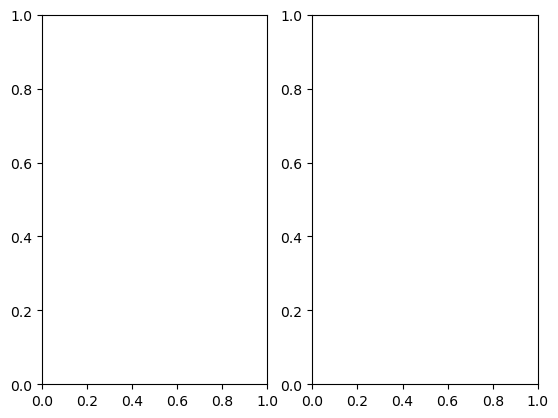

In [88]:

fig = plt.figure() #branca.element.Figure()

subplot1 = fig.add_subplot(1, 2, 1)
subplot2 = fig.add_subplot(1, 2, 2)

# subplot1.add_child(
#     folium.Map([0, 0], zoom_start=1)
# )
# subplot2.add_child(
#     folium.Map([46, 3], tiles="OpenStreetMap", zoom_start=5)
# )

subplot.

fig

In [96]:
from selenium import webdriver
from selenium.webdriver.firefox.options import Options

# options = Options()
# options.add_argument("--headless")
# driver = webdriver.Firefox(options=options)
# driver.get('https://www.google.com/')

op = webdriver.ChromeOptions()
op.add_argument('headless')
driver = webdriver.Chrome(options=op)

NoSuchDriverException: Message: Unable to obtain driver for chrome; For documentation on this error, please visit: https://www.selenium.dev/documentation/webdriver/troubleshooting/errors/driver_location


In [77]:
desired_features_input_and_output = ["diff_time", 
                                  "lat_complex_x", 
                                  "lat_complex_y", 
                                  "long_complex_x", 
                                  "long_complex_y", 
                                  "flight_course_corrected", 
                                  "flight_course_unknown", 
                                  "Latitude", 
                                  "Longitude"]

desired_input_features = ["diff_time", 
                          "lat_complex_x", 
                          "lat_complex_y", 
                          "long_complex_x", 
                          "long_complex_y", 
                          "flight_course_corrected", 
                          "flight_course_unknown", 
                            "Latitude", 
                            "Longitude"]


desired_output_features = ["lat_complex_x", 
                          "lat_complex_y", 
                          "long_complex_x", 
                          "long_complex_y"]




datamodule = Datamodule(all_flight_dataframes_dict = flight_dfs, 
                        num_input_rows_total = 200, 
                        min_rows_input = 10, 
                        num_output_rows = 1, 
                        desired_features_input_and_output = desired_features_input_and_output, 
                        desired_input_features = desired_input_features,
                        desired_output_features = None, 
                        train_prop = 0.8, 
                        batch_size = 32, 
                        num_workers = 0, 
                        pin_memory = True,)

train_dataloader = datamodule.train_dataloader()
test_dataloader = datamodule.test_dataloader()




In [82]:
test_dataloader_iterator = test_dataloader.__iter__()
tensors_dict = next(test_dataloader_iterator)
tensors_dict

iter input_output_tensors_dict[input_tensor][: , 1:5]:  tensor([[ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.000

{'input_tensor': tensor([[[  0.0000,   0.0000,   0.0000,  ...,  -4.0000,  -5.0000,  -5.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.7314,   0.7313,   0.7313],
          [  0.0000,   0.0000,   0.0000,  ...,   0.6820,   0.6821,   0.6821],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,  43.0002,  43.0043,  43.0086],
          [  0.0000,   0.0000,   0.0000,  ..., -81.5541, -81.5436, -81.5331]],
 
         [[  0.0000,   0.0000,   0.0000,  ...,  -5.0000,  -5.0000,  -5.0000],
          [  0.0000,   0.0000,   0.0000,  ...,   0.7313,   0.7313,   0.7312],
          [  0.0000,   0.0000,   0.0000,  ...,   0.6821,   0.6821,   0.6822],
          ...,
          [  0.0000,   0.0000,   0.0000,  ...,   0.0000,   0.0000,   0.0000],
          [  0.0000,   0.0000,   0.0000,  ...,  43.0043,  43.0086,  43.0139],
          [  0.0000,   0.0000,   0.0000,  ..., -81.5436, -81.5331, -81.5228]],
 
         [[ 

In [83]:
for v, t in tensors_dict.items():
    print(v, t.shape)

input_tensor torch.Size([32, 9, 200])
output_tensor torch.Size([32, 4, 1])
normalization_tensor torch.Size([32, 4, 1])


In [93]:
# input_tensor torch.Size([32, 9, 200])
# output_tensor torch.Size([32, 4, 1])
# normalization_tensor torch.Size([32, 4, 1])

input = tensors_dict["input_tensor"]
output = tensors_dict["output_tensor"]
norm =   tensors_dict["normalization_tensor"] #[:, :, 0]

normalized_tensor = input[:, 1:5, :] - norm #[:, :, None]
normalized_tensor

tensor([[[-7.3125e-01, -7.3125e-01, -7.3125e-01,  ...,  1.0085e-04,
           5.1320e-05,  0.0000e+00],
         [-6.8211e-01, -6.8211e-01, -6.8211e-01,  ..., -1.0812e-04,
          -5.5015e-05,  0.0000e+00],
         [-1.4724e-01, -1.4724e-01, -1.4724e-01,  ..., -3.6253e-04,
          -1.8178e-04,  0.0000e+00],
         [ 9.8910e-01,  9.8910e-01,  9.8910e-01,  ..., -5.3883e-05,
          -2.7001e-05,  0.0000e+00]],

        [[-7.3119e-01, -7.3119e-01, -7.3119e-01,  ...,  1.1379e-04,
           6.2466e-05,  0.0000e+00],
         [-6.8218e-01, -6.8218e-01, -6.8218e-01,  ..., -1.2201e-04,
          -6.6996e-05,  0.0000e+00],
         [-1.4742e-01, -1.4742e-01, -1.4742e-01,  ..., -3.6010e-04,
          -1.7832e-04,  0.0000e+00],
         [ 9.8907e-01,  9.8907e-01,  9.8907e-01,  ..., -5.3585e-05,
          -2.6584e-05,  0.0000e+00]],

        [[-7.3114e-01, -7.3114e-01, -7.3114e-01,  ...,  1.1438e-04,
           5.1916e-05,  0.0000e+00],
         [-6.8223e-01, -6.8223e-01, -6.8223e-01,  .

In [90]:
input[0, :, -1]

tensor([ -5.0000,   0.7313,   0.6821,   0.1472,  -0.9891,  61.0000,   0.0000,
         43.0086, -81.5331])

In [94]:
norm[0, :, -1]

tensor([ 0.7313,  0.6821,  0.1472, -0.9891])

In [79]:
sample_input = tensors_dict["input_tensor"][0]
sample_output = tensors_dict["output_tensor"][0]
sample_norm =   tensors_dict["normalization_tensor"][0]


print("input output tensor shapes", sample_input.shape, sample_output.shape, sample_norm.shape)


complex_coors_input = sample_input[1:5, :] # complex coors columns of dataframe converted to tensor

lat = sample_input[-2, :]
long = sample_input[-1, :]

lat_x = complex_coors_input[0, :]
lat_y = complex_coors_input[1, :]
long_x = complex_coors_input[2, :]
long_y = complex_coors_input[3, :]

norm_lat_x = sample_norm[0]
norm_lat_y = sample_norm[1]
norm_long_x = sample_norm[2]
norm_long_y = sample_norm[3]


#norm_long_deg = complex_number_to_degrees(norm_long_x, norm_long_y)

x = long_x #+ norm_long_x
y = long_y #+ norm_long_y

print("norm_long_x, norm_long_y, norm_long_deg: ", norm_long_x, norm_long_y, "\n")
print(complex_number_to_degrees(x, y)[-10:], "\n")
print(long[-10:], "\n")

input output tensor shapes torch.Size([9, 200]) torch.Size([4, 1]) torch.Size([4, 1])
norm_long_x, norm_long_y, norm_long_deg:  tensor([0.1472]) tensor([-0.9891]) 

tensor([-81.6276, -81.6173, -81.6082, -81.5962, -81.5859, -81.5751, -81.5647,
        -81.5541, -81.5436, -81.5331]) 

tensor([-81.6276, -81.6173, -81.6082, -81.5962, -81.5859, -81.5751, -81.5647,
        -81.5541, -81.5436, -81.5331]) 



In [72]:
long_x, long_y

(tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251,
         -0.4251, -0.4251, -0.4251, -0.4251]),
 tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052,
         -0.9052, -0.9052, -0.9052, -0.9052]))

In [71]:
sample_norm

tensor([[ 0.8081],
        [ 0.5890],
        [-0.4251],
        [-0.9052]])

In [65]:
complex_coors_input

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.8081,  0.8081,  0.8081,  0.8081,  0.8081,  0.8081,
          0.8081,  0.8081,  0.8081,  0.8081],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.5890,  0.5890,  0.5890,  0.5890,  0.5890,  0.5890,
          0.5890,  0.5890,  0.5890,  0.5890],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251,
         -0.4251, -0.4251, -0.4251, -0.4251],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052,
         -0.9052, -0.9052, -0.9052, -0.9052]])

In [54]:
complex_coors_input[:, -1]

tensor([ 0.8081,  0.5890, -0.4251, -0.9052])

In [55]:
complex_coors_input[:, 0]

tensor([0., 0., 0., 0.])

In [56]:
t = complex_coors_input - sample_norm
t#[:, -1]

tensor([[-8.0813e-01, -8.0813e-01, -8.0813e-01, -8.0813e-01, -8.0813e-01,
         -8.0813e-01, -8.0813e-01, -8.0813e-01, -8.0813e-01, -8.0813e-01,
         -2.7418e-06, -2.4438e-06, -2.4438e-06, -2.1458e-06, -1.7285e-06,
         -1.4305e-06, -1.1325e-06, -5.9605e-07, -4.7684e-07,  0.0000e+00],
        [-5.8900e-01, -5.8900e-01, -5.8900e-01, -5.8900e-01, -5.8900e-01,
         -5.8900e-01, -5.8900e-01, -5.8900e-01, -5.8900e-01, -5.8900e-01,
          3.8147e-06,  3.3975e-06,  3.3975e-06,  2.9802e-06,  2.3842e-06,
          1.9670e-06,  1.5497e-06,  8.3447e-07,  7.1526e-07,  0.0000e+00],
        [ 4.2508e-01,  4.2508e-01,  4.2508e-01,  4.2508e-01,  4.2508e-01,
          4.2508e-01,  4.2508e-01,  4.2508e-01,  4.2508e-01,  4.2508e-01,
          6.9737e-06,  6.4969e-06,  5.5432e-06,  4.5896e-06,  3.6359e-06,
          2.8610e-06,  2.2352e-06,  1.5795e-06,  8.0466e-07,  0.0000e+00],
        [ 9.0516e-01,  9.0516e-01,  9.0516e-01,  9.0516e-01,  9.0516e-01,
          9.0516e-01,  9.0516e-01, 

In [57]:

complex_coors_input - sample_norm

# Normalize previous coordinates by last coordinate
# input_output_tensors_dict["input_tensor"][:, 1: 5] = input_output_tensors_dict["input_tensor"][:, 1: 5] - last_complex_coor
# # Normalize future coordinates by last coordinate
# input_output_tensors_dict["output_tensor"] = input_output_tensors_dict["output_tensor"] - last_complex_coor

tensor([[ 0.8081,  0.8081,  0.8081,  0.8081,  0.8081,  0.8081,  0.8081,  0.8081,
          0.8081,  0.8081,  1.6163,  1.6163,  1.6163,  1.6163,  1.6163,  1.6163,
          1.6163,  1.6163,  1.6163,  1.6163],
        [ 0.5890,  0.5890,  0.5890,  0.5890,  0.5890,  0.5890,  0.5890,  0.5890,
          0.5890,  0.5890,  1.1780,  1.1780,  1.1780,  1.1780,  1.1780,  1.1780,
          1.1780,  1.1780,  1.1780,  1.1780],
        [-0.4251, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251, -0.4251,
         -0.4251, -0.4251, -0.8502, -0.8502, -0.8502, -0.8502, -0.8502, -0.8502,
         -0.8502, -0.8502, -0.8502, -0.8502],
        [-0.9052, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052, -0.9052,
         -0.9052, -0.9052, -1.8103, -1.8103, -1.8103, -1.8103, -1.8103, -1.8103,
         -1.8103, -1.8103, -1.8103, -1.8103]])

In [58]:
t = torch.rand(30, 7)
c = copy.deepcopy(t[-1, :])

t

tensor([[0.4022, 0.0946, 0.3024, 0.0895, 0.4175, 0.6948, 0.8308],
        [0.9963, 0.3102, 0.7892, 0.0777, 0.7950, 0.7414, 0.7366],
        [0.6221, 0.4177, 0.7714, 0.7394, 0.9100, 0.1911, 0.0389],
        [0.4944, 0.4359, 0.0806, 0.3308, 0.4694, 0.9296, 0.9553],
        [0.7778, 0.1916, 0.7720, 0.5873, 0.7985, 0.4763, 0.6083],
        [0.5072, 0.9645, 0.9527, 0.7639, 0.0521, 0.0521, 0.7618],
        [0.8707, 0.8600, 0.4563, 0.8189, 0.2546, 0.4997, 0.3885],
        [0.3963, 0.7341, 0.3642, 0.2663, 0.2750, 0.0458, 0.2601],
        [0.2282, 0.7040, 0.8366, 0.4086, 0.6373, 0.5415, 0.0296],
        [0.6676, 0.0379, 0.1959, 0.8112, 0.1684, 0.8317, 0.9898],
        [0.6770, 0.5609, 0.9087, 0.2988, 0.9426, 0.5117, 0.1220],
        [0.0427, 0.1644, 0.1777, 0.4935, 0.9572, 0.5993, 0.3803],
        [0.4429, 0.9436, 0.0474, 0.6142, 0.8917, 0.1746, 0.0098],
        [0.4608, 0.7120, 0.1822, 0.0316, 0.0313, 0.1790, 0.8689],
        [0.5660, 0.1616, 0.6492, 0.8220, 0.6848, 0.1664, 0.4856],
        [0

In [59]:
t - c

tensor([[-1.0433e-01,  4.2196e-02, -4.8221e-01, -8.7806e-01, -5.4830e-01,
          4.9726e-01,  3.5938e-01],
        [ 4.8976e-01,  2.5778e-01,  4.5233e-03, -8.8977e-01, -1.7075e-01,
          5.4383e-01,  2.6520e-01],
        [ 1.1550e-01,  3.6531e-01, -1.3194e-02, -2.2811e-01, -5.5773e-02,
         -6.4825e-03, -4.3247e-01],
        [-1.2149e-02,  3.8353e-01, -7.0407e-01, -6.3669e-01, -4.9641e-01,
          7.3200e-01,  4.8394e-01],
        [ 2.7124e-01,  1.3926e-01, -1.2615e-02, -3.8018e-01, -1.6730e-01,
          2.7877e-01,  1.3691e-01],
        [ 6.4898e-04,  9.1212e-01,  1.6809e-01, -2.0359e-01, -9.1369e-01,
         -1.4549e-01,  2.9043e-01],
        [ 3.6412e-01,  8.0759e-01, -3.2834e-01, -1.4862e-01, -7.1118e-01,
          3.0216e-01, -8.2912e-02],
        [-1.1024e-01,  6.8167e-01, -4.2043e-01, -7.0121e-01, -6.9080e-01,
         -1.5173e-01, -2.1134e-01],
        [-2.7838e-01,  6.5164e-01,  5.2014e-02, -5.5890e-01, -3.2845e-01,
          3.4393e-01, -4.4181e-01],
        [ 

In [60]:
lat_x

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.8081, 0.8081, 0.8081, 0.8081, 0.8081, 0.8081, 0.8081, 0.8081,
        0.8081, 0.8081])

In [390]:
sample_norm.shape

torch.Size([4, 1])

In [381]:
complex_coors_input = sample_input[1:5, :]
lat = sample_input[-2, :]
long = sample_input[-1, :]
complex_coors_input

tensor([[ -0.9002,  -1.8004,  -2.7005,  ..., -27.8677, -27.8677, -27.8678],
        [ -0.4355,  -0.8710,  -1.3066,  ..., -13.5776, -13.5776, -13.5775],
        [ -0.1735,  -0.3471,  -0.5208,  ...,  -5.3970,  -5.3969,  -5.3968],
        [  0.9848,   1.9696,   2.9544,  ...,  30.5255,  30.5255,  30.5256]])

In [382]:
complex_coors_input.shape

torch.Size([4, 1000])

In [386]:
lat_x = complex_coors_input[0, :]
lat_y = complex_coors_input[1, :]
long_x = complex_coors_input[2, :]
long_y = complex_coors_input[3, :]

norm_lat_x = sample_norm[0]
norm_lat_y = sample_norm[1]
norm_long_x = sample_norm[2]
norm_long_y = sample_norm[3]


norm_long_deg = complex_number_to_degrees(norm_long_x, norm_long_y)

x = long_x #+ norm_long_x
y = long_y #+ norm_long_y

print(norm_long_x, norm_long_y, norm_long_deg)
complex_number_to_degrees(x, y)[-10:] 

tensor([0.1735]) tensor([-0.9848]) tensor([-80.0075])


tensor([100.0276, 100.0274, 100.0272, 100.0270, 100.0269, 100.0267, 100.0265,
        100.0264, 100.0262, 100.0260])

In [384]:
long[-10:]

tensor([-80.0582, -80.0507, -80.0449, -80.0396, -80.0344, -80.0295, -80.0245,
        -80.0185, -80.0129, -80.0075])

In [385]:
long_x, long_y

(tensor([-0.1735, -0.3471, -0.5208, -0.6947, -0.8686, -1.0426, -1.2167, -1.3909,
         -1.5652, -1.7396, -1.9141, -2.0887, -2.2634, -2.4382, -2.6132, -2.7882,
         -2.9633, -3.1386, -3.3139, -3.4895, -3.6654, -3.8416, -4.0180, -4.1947,
         -4.3717, -4.5490, -4.7266, -4.9045, -5.0827, -5.2613, -5.4401, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703, -5.5703,
         -5.5703, -5.5703, -

In [365]:
norm_long_x, norm_long_y

(tensor(0.2482), tensor(-0.9687))

In [332]:
lat[-10:]

tensor([36.3450, 36.3447, 36.3445, 36.3443, 36.3440, 36.3439, 36.3438, 36.3437,
        36.3437, 36.3436])

In [334]:
tensors_dict["input_tensor"][-1][-2, :][-10:]

tensor([36.3415, 36.3410, 36.3405, 36.3399, 36.3392, 36.3384, 36.3378, 36.3370,
        36.3363, 36.3355])

In [335]:
sample_norm

tensor([ 0.8055,  0.5926, -0.1331, -0.9911])

In [337]:
long_x[-10:]

tensor([-0.1336, -0.1335, -0.1335, -0.1334, -0.1333, -0.1333, -0.1332, -0.1332,
        -0.1331, -0.1331])

In [307]:
# # Latitude is specified in degrees within the range [-90, 90]. 
# # Longitude is specified in degrees within the range [-180, 180].

# def degrees_to_radians(some_degrees_angle):
#     radians_angle = some_degrees_angle * np.pi / 180.0
#     return radians_angle

# def radians_to_degrees(some_radians_angle):
#     degrees_angle = some_radians_angle * 180.0 / np.pi
#     return degrees_angle
    
# def angle_to_complex_encoding(degrees):
#     """
#     Angle representation (lat/long) fed into models can have sudden sharp discontinuities, to aleviate this we can use a "complex number" 
#     representation of each of the coordinate in the coordinate pair. Method transforms either Lattitude or Longgitude into "complex reperesentaion"
#     """
#     radians = degrees_to_radians(degrees)
#     complex_x = np.cos(radians)
#     complex_y = np.sin(radians)
#     return complex_x, complex_y

# def complex_number_to_degrees(complex_x, complex_y):
#     radians = np.arctan2(complex_y, complex_x)
#     degrees = radians_to_degrees(radians)
#     return degrees

In [212]:
def compose_rd_dataframe(rd_filepaths_list):
    """
    Read in rd files and concatinate them
    return combined rd file 
    """

    rd_list = [d["RD"] for d in files_dict.values()]
    #dataframes_list = [pd.read_csv(filepath_rd, usecols=["Msn", "Orig", "EstOrig", "Dest", "EstDest"]) for filepath_rd in rd_list]
    dataframes_list = [pd.read_csv(filepath_rd) for filepath_rd in rd_list]
    rd_dataframe = pd.concat(dataframes_list, axis=0, ignore_index=True)
    return rd_dataframe
    
dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
files_dict = group_files_by_type(dir_csv)

rd_dataframe = compose_rd_dataframe(files_dict)
rd_dataframe

,lKey,cKey,SysName,StartDate,StartTime,tMidnightSecs,tStartSecs,tStopSecs,tStart,tStop,...,Centers,TRACONs,Sectors,SUAs,SpAirsp,LclAirsp,NavObjs,ClssAirsp,equipList,RDVersion
0,16884,USA_20240518_050248_16884,usa,05/18/2024,04:53:10,1.715990e+09,1.716008e+09,1.716009e+09,17589.526,18168.306,...,OUTSIDE,NONE,OUTSIDE,NONE,NONE,NONE,NONE,NONE,?,2
1,16900,USA_20240518_050620_16900,usa,05/18/2024,04:58:55,1.715990e+09,1.716008e+09,1.716009e+09,17935.395,18379.997,...,OUTSIDE,NONE,OUTSIDE,NONE,NONE,NONE,NONE,NONE,?,2
2,16911,USA_20240518_052142_16911,usa,05/18/2024,05:14:18,1.715990e+09,1.716009e+09,1.716010e+09,18858.189,19302.358,...,OUTSIDE,NONE,OUTSIDE,NONE,NONE,NONE,NONE,NONE,?,2
3,17008,USA_20240518_050018_17008,usa,05/18/2024,04:33:42,1.715990e+09,1.716007e+09,1.716008e+09,16422.112,18017.899,...,OUTSIDE,NONE,OKA@ZFW,NONE,NONE,NONE,NONE,NONE,?,2
4,17031,USA_20240518_051326_17031,usa,05/18/2024,05:09:38,1.715990e+09,1.716009e+09,1.716009e+09,18577.843,18805.972,...,OUTSIDE,NONE,MMM@ZMP,NONE,NONE,NONE,NONE,NONE,?,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234221,112797,USA_20240517_040315_112797,usa,05/17/2024,02:43:15,1.715904e+09,1.715914e+09,1.715919e+09,9795.000,14594.965,...,OUTSIDE|ZMP@ZMP|ZAU@ZAU|OUTSIDE,NONE,MMM@ZMP|21@ZMP|15@ZMP|76@ZAU|94@ZAU|83@ZAU|47@...,NONE,NONE,NONE,NONE,NONE,1H/L,2
234222,112801,USA_20240517_035445_112801,usa,05/17/2024,03:29:15,1.715904e+09,1.715917e+09,1.715918e+09,12555.000,14085.000,...,OUTSIDE,NONE,OUTSIDE,NONE,NONE,NONE,NONE,NONE,F/,2
234223,113120,USA_20240517_040749_113120,usa,05/17/2024,01:13:59,1.715904e+09,1.715908e+09,1.715919e+09,4439.000,14869.000,...,OUTSIDE|ZMA@ZMA|ZJX@ZJX|ZDC@ZDC|ZNY@ZNY|OUTSIDE,NONE,OUTSIDE|60@ZMA|59@ZMA|19@ZMA|35@ZJX|52@ZJX|NVF...,NONE,NONE,NONE,NONE,NONE,/L,2
234224,113161,USA_20240517_045504_113161,usa,05/17/2024,04:53:16,1.715904e+09,1.715922e+09,1.715922e+09,17596.223,17704.269,...,ZAB@ZAB,NONE,42@ZAB,NONE,NONE,NONE,NONE,NONE,?,2


In [213]:
list(rd_dataframe.columns.values)

['lKey',
 'cKey',
 'SysName',
 'StartDate',
 'StartTime',
 'tMidnightSecs',
 'tStartSecs',
 'tStopSecs',
 'tStart',
 'tStop',
 'Duration',
 'Msn',
 'AcId',
 'AcType',
 'FltIdx',
 'PC',
 'WC',
 'Cid',
 'Bcn',
 'OT',
 'Airline',
 'CT',
 'Orig',
 'EstOrig',
 'TOFRwy',
 'Dest',
 'EstDest',
 'LNDRwy',
 'tTOC',
 'tTOD',
 'FFXName',
 'FFXDist',
 'tFFX',
 'ATAThdDep',
 'ATACtrDep',
 'ATAOutDep',
 'ATACtrArr',
 'ATATcnArr',
 'ATAThdArr',
 'ETAThdArrO',
 'ETAThdArrI',
 'tOAGDep',
 'tOAGArr',
 'tOUT',
 'tTAXI',
 'tOFF',
 'tON',
 'tIN',
 'FacName',
 'Field10',
 'Systems',
 'FIRs',
 'Centers',
 'TRACONs',
 'Sectors',
 'SUAs',
 'SpAirsp',
 'LclAirsp',
 'NavObjs',
 'ClssAirsp',
 'equipList',
 'RDVersion']

In [220]:
unique_origins_list = list(rd_dataframe["Orig"].unique())
for idx_orig, orig in enumerate(unique_origins_list):
    print(orig)

    if idx_orig > 100:
        break

?
FFF
HTO224076
MLS282121
KATL
ZBV242018
3G8
LMT183057
KIAD
LABRE030006
KLAS
VIO027015
GEP282010
ZFP247046
37.433333/-88.466667
PXV215024
PXV232005
AIR121080
37.350000/-88.033333
KMDW
EMI292063
IHD116052
PXV240026
DHP143024
KCLT
KDEN
RNL
EEE
ANC
FAI
ONL039043
LRD327074
KLAX
MDST
KINCH
32.783333/-68.200000
MTU078045
KTPA
BKE332025
SYR049081
KDFW
KEWR
VUH121061
KJFK
JFK055025
40.050000/-88.433333
KMIA
LAL269015
KGLR
unassigned
TJBQ
KXWA
JIMAC
VUZ352048
FSD313052
OED172070
HRO106066
W99
DIK327049
KSFO
AVE248058
KROST054116
POISN026023
PINTE349008
PINTE331006
ATENE229006
RWT
DASER
25.183333/-71.083333
BETIR
GEECE
JHW065024
HNK229004
VKZ115017
ZZV004039
KSLC
CIP094044
DIK340065
ENE232052
ZBV326023
KMCO
HTO228051
HTO131014
SYR323034
ODI113033
GEP013079
SJT236018
ANTIG
SATOE
SAT016012
DIK219020
HANCY
OPAUL
ATENE231005
OAL046026
TBC251020
PGS058025
MLC044023
IMB091044
BCE126039
KSTL
FLL291024


In [214]:
rd_dataframe[["Msn", "Orig", "EstOrig", "Dest", "EstDest"]]

,Msn,Orig,EstOrig,Dest,EstDest
0,34088,?,?,?,?
1,34104,?,?,?,?
2,34115,?,?,?,?
3,34212,?,?,?,OUN
4,34235,?,?,?,ANE
...,...,...,...,...,...
234221,226731,KMSP,MSP,KIND,IND
234222,226735,?,?,?,HNL
234223,228102,ILM161067,?,KJFK,JFK
234224,228143,?,?,?,?


In [200]:
dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
files_dict = group_files_by_type(dir_csv)
files_dict

defaultdict(<function __main__.group_files_by_type.<locals>.<lambda>()>,
            {'USA_20240518_050003_86395_LADDfiltered': {'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv',
              'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240518_050003_86395_LADDfiltered.csv',
              'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240518_050003_86395_LADDfiltered.csv'},
             'USA_20240517_050002_86397_LADDfiltered': {'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240517_050002_86397_LADDfiltered.csv',
              'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240517_050002_86397_LADDfiltered.csv',
              'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240517_050002_86397_LADDfiltered.csv'},
             'USA_20240516_

In [201]:
dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
files_dict = group_files_by_type(dir_csv)
files_dict


rd_dataframe = pd.read_csv(filepath_rd, usecols=["Msn", "Orig", "EstOrig", "Dest", "EstDest"])
rd_dataframe

NameError: name 'filepath_rd' is not defined

In [205]:
rd_list = [d["RD"] for d in files_dict.values()]


In [204]:
files_dict

defaultdict(<function __main__.group_files_by_type.<locals>.<lambda>()>,
            {'USA_20240518_050003_86395_LADDfiltered': {'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv',
              'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240518_050003_86395_LADDfiltered.csv',
              'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240518_050003_86395_LADDfiltered.csv'},
             'USA_20240517_050002_86397_LADDfiltered': {'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240517_050002_86397_LADDfiltered.csv',
              'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240517_050002_86397_LADDfiltered.csv',
              'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240517_050002_86397_LADDfiltered.csv'},
             'USA_20240516_

In [174]:
c = len(["diff_time", 
          "lat_complex_x", 
          "lat_complex_y", 
          "long_complex_x", 
          "long_complex_y", 
          "flight_course_corrected", 
          "flight_course_unknown"])

t = torch.rand(20, c)
t

tensor([[0.5145, 0.2094, 0.1876, 0.3269, 0.5296, 0.4465, 0.6978],
        [0.8440, 0.3661, 0.3491, 0.9442, 0.3833, 0.0503, 0.0598],
        [0.0279, 0.6705, 0.3473, 0.4355, 0.5476, 0.2469, 0.8609],
        [0.2944, 0.7982, 0.1805, 0.0669, 0.9471, 0.8335, 0.5747],
        [0.3627, 0.2309, 0.1493, 0.7746, 0.0719, 0.1045, 0.5746],
        [0.4714, 0.4989, 0.3554, 0.0418, 0.2120, 0.1614, 0.7043],
        [0.2100, 0.1048, 0.2677, 0.9540, 0.8367, 0.8947, 0.3400],
        [0.7992, 0.6229, 0.5194, 0.0610, 0.5357, 0.6083, 0.2019],
        [0.7395, 0.4499, 0.8792, 0.5722, 0.3617, 0.4756, 0.7853],
        [0.6494, 0.6805, 0.2829, 0.1945, 0.8770, 0.1676, 0.7747],
        [0.1171, 0.3997, 0.0681, 0.0227, 0.9653, 0.4329, 0.0567],
        [0.2703, 0.8024, 0.5992, 0.0692, 0.4228, 0.0629, 0.3350],
        [0.8927, 0.5013, 0.6874, 0.7756, 0.0097, 0.8799, 0.1756],
        [0.4727, 0.4917, 0.9692, 0.1492, 0.5508, 0.2190, 0.5536],
        [0.2448, 0.4325, 0.0958, 0.6149, 0.1074, 0.6553, 0.3242],
        [0

In [178]:
t[:, 1:5]

tensor([[0.2094, 0.1876, 0.3269, 0.5296],
        [0.3661, 0.3491, 0.9442, 0.3833],
        [0.6705, 0.3473, 0.4355, 0.5476],
        [0.7982, 0.1805, 0.0669, 0.9471],
        [0.2309, 0.1493, 0.7746, 0.0719],
        [0.4989, 0.3554, 0.0418, 0.2120],
        [0.1048, 0.2677, 0.9540, 0.8367],
        [0.6229, 0.5194, 0.0610, 0.5357],
        [0.4499, 0.8792, 0.5722, 0.3617],
        [0.6805, 0.2829, 0.1945, 0.8770],
        [0.3997, 0.0681, 0.0227, 0.9653],
        [0.8024, 0.5992, 0.0692, 0.4228],
        [0.5013, 0.6874, 0.7756, 0.0097],
        [0.4917, 0.9692, 0.1492, 0.5508],
        [0.4325, 0.0958, 0.6149, 0.1074],
        [0.2452, 0.3205, 0.8235, 0.7022],
        [0.5674, 0.4218, 0.6411, 0.8789],
        [0.6103, 0.1501, 0.9881, 0.3013],
        [0.0528, 0.6813, 0.3122, 0.5523],
        [0.9302, 0.5614, 0.5617, 0.2904]])

In [179]:
last_complex_coor = torch.as_tensor([1, 2, 3, 4])
last_complex_coor

tensor([1, 2, 3, 4])

In [180]:
t[:, 1:5] - last_complex_coor

tensor([[-0.7906, -1.8124, -2.6731, -3.4704],
        [-0.6339, -1.6509, -2.0558, -3.6167],
        [-0.3295, -1.6527, -2.5645, -3.4524],
        [-0.2018, -1.8195, -2.9331, -3.0529],
        [-0.7691, -1.8507, -2.2254, -3.9281],
        [-0.5011, -1.6446, -2.9582, -3.7880],
        [-0.8952, -1.7323, -2.0460, -3.1633],
        [-0.3771, -1.4806, -2.9390, -3.4643],
        [-0.5501, -1.1208, -2.4278, -3.6383],
        [-0.3195, -1.7171, -2.8055, -3.1230],
        [-0.6003, -1.9319, -2.9773, -3.0347],
        [-0.1976, -1.4008, -2.9308, -3.5772],
        [-0.4987, -1.3126, -2.2244, -3.9903],
        [-0.5083, -1.0308, -2.8508, -3.4492],
        [-0.5675, -1.9042, -2.3851, -3.8926],
        [-0.7548, -1.6795, -2.1765, -3.2978],
        [-0.4326, -1.5782, -2.3589, -3.1211],
        [-0.3897, -1.8499, -2.0119, -3.6987],
        [-0.9472, -1.3187, -2.6878, -3.4477],
        [-0.0698, -1.4386, -2.4383, -3.7096]])

In [183]:
t3 = t[:, 1:5]
t3.shape

torch.Size([20, 4])

In [184]:
t3 - last_complex_coor

tensor([[-0.7906, -1.8124, -2.6731, -3.4704],
        [-0.6339, -1.6509, -2.0558, -3.6167],
        [-0.3295, -1.6527, -2.5645, -3.4524],
        [-0.2018, -1.8195, -2.9331, -3.0529],
        [-0.7691, -1.8507, -2.2254, -3.9281],
        [-0.5011, -1.6446, -2.9582, -3.7880],
        [-0.8952, -1.7323, -2.0460, -3.1633],
        [-0.3771, -1.4806, -2.9390, -3.4643],
        [-0.5501, -1.1208, -2.4278, -3.6383],
        [-0.3195, -1.7171, -2.8055, -3.1230],
        [-0.6003, -1.9319, -2.9773, -3.0347],
        [-0.1976, -1.4008, -2.9308, -3.5772],
        [-0.4987, -1.3126, -2.2244, -3.9903],
        [-0.5083, -1.0308, -2.8508, -3.4492],
        [-0.5675, -1.9042, -2.3851, -3.8926],
        [-0.7548, -1.6795, -2.1765, -3.2978],
        [-0.4326, -1.5782, -2.3589, -3.1211],
        [-0.3897, -1.8499, -2.0119, -3.6987],
        [-0.9472, -1.3187, -2.6878, -3.4477],
        [-0.0698, -1.4386, -2.4383, -3.7096]])

In [130]:
t = torch.rand(32, 4, 30)
t.shape

torch.Size([32, 4, 30])

In [136]:
t.flatten(start_dim=1, end_dim=2).shape

torch.Size([32, 120])

In [154]:
sample_df = flight_dfs[34088]
sample_df

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
122938699,34088,NaN,2021,1716007989,48.74302,-91.34878,80.0,AIG200,1,1,187,114
122938700,34088,NaN,2021,1716008001,48.73877,-91.33446,84.0,AIG200,1,2,187,114
122938701,34088,NaN,2021,1716008013,48.73531,-91.32056,87.0,AIG200,1,6,177,111
122938702,34088,NaN,2021,1716008025,48.73140,-91.30533,90.0,AIG200,1,2,195,111
122938703,34088,NaN,2021,1716008037,48.72654,-91.29059,93.0,AIG200,1,4,197,117
122938704,34088,NaN,2021,1716008049,48.72224,-91.27403,95.0,AIG200,1,6,213,111
122938705,34088,NaN,2021,1716008061,48.71916,-91.25733,97.0,AIG200,1,9,207,106
122938706,34088,NaN,2021,1716008073,48.71601,-91.24183,99.0,AIG200,1,2,193,107
122938707,34088,NaN,2021,1716008085,48.71319,-91.22501,102.0,AIG200,1,8,207,104
122938708,34088,NaN,2021,1716008097,48.71089,-91.20834,104.0,AIG200,1,4,203,102


In [159]:
long_diff = -90.51382 - (-90.53513)
lat_diff = 48.58668 - (48.59233)
lat_diff, long_diff

(-0.005649999999995714, 0.021309999999999718)

In [167]:
# fltKey	CID	UAID	Time	Latitude	Longitude	Altitude	PointSource	RecTypeCat	Significance	GroundSpeed	FlightCourse
lat_long_sample_dfs = sample_df[["Latitude", "Longitude"]]

# .diff(-1)
diff_long = lat_long_sample_dfs[["Latitude"]].diff(1)
diff_lat  = lat_long_sample_dfs[["Longitude"]].diff(1)
lat_long_sample_dfs["diff_long"] = diff_long
lat_long_sample_dfs["diff_lat"] = diff_lat

lat_long_sample_dfs.fillna(value=0.0)


/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_28365/988750129.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lat_long_sample_dfs["diff_long"] = diff_long
/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_28365/988750129.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lat_long_sample_dfs["diff_lat"] = diff_lat


,Latitude,Longitude,diff_long,diff_lat
122938699,48.74302,-91.34878,0.00000,0.00000
122938700,48.73877,-91.33446,-0.00425,0.01432
122938701,48.73531,-91.32056,-0.00346,0.01390
122938702,48.73140,-91.30533,-0.00391,0.01523
122938703,48.72654,-91.29059,-0.00486,0.01474
122938704,48.72224,-91.27403,-0.00430,0.01656
122938705,48.71916,-91.25733,-0.00308,0.01670
122938706,48.71601,-91.24183,-0.00315,0.01550
122938707,48.71319,-91.22501,-0.00282,0.01682
122938708,48.71089,-91.20834,-0.00230,0.01667


In [160]:
# (-0.005649999999995714, 0.021309999999999718)

In [164]:
lat_long_diff_df.iloc[-1]

Latitude    -0.00565
Longitude    0.02131
Name: 122938745, dtype: float64

In [ ]:
np.arctan2(

In [371]:
t = torch.as_tensor([1, 2, 3, 4])
torch.unqueeze(t, 0)

AttributeError: module 'torch' has no attribute 'unqueeze'

In [120]:
msn = list(flight_dfs.keys())
msn

[34088,
 34104,
 34115,
 34212,
 34235,
 34278,
 34307,
 35332,
 35391,
 35405,
 35410,
 35420,
 35483,
 35578,
 35630,
 35716,
 35739,
 35748,
 35761,
 35794,
 35802,
 35804,
 35810,
 35820,
 35824,
 35828,
 35834,
 35840,
 35841,
 35842,
 35854,
 35873,
 35909,
 35916,
 35918,
 35919,
 35928,
 35931,
 35934,
 35952,
 35955,
 36008,
 36009,
 36015,
 36016,
 36017,
 36018,
 36020,
 36021,
 36023,
 36039,
 36064,
 36065,
 36075,
 36076,
 36081,
 36084,
 36086,
 36089,
 36090,
 36091,
 36092,
 36093,
 36094,
 36097,
 36098,
 36099,
 36100,
 36101,
 36103,
 36104,
 36105,
 36106,
 36107,
 36108,
 36109,
 36110,
 36111,
 36112,
 36113,
 36114,
 36115,
 36116,
 36117,
 36118,
 36119,
 36124,
 36897,
 36914,
 36985,
 37087,
 37097,
 37176,
 37184,
 37202,
 37232,
 37260,
 37273,
 37276,
 37298,
 37299,
 37305,
 37310,
 37311,
 37330,
 37335,
 37344,
 37347,
 37352,
 37362,
 37366,
 37367,
 37368,
 37374,
 37378,
 37379,
 37382,
 37383,
 37384,
 37385,
 37386,
 37387,
 37388,
 37389,
 37390,


In [121]:
random.shuffle(msn)

In [122]:
msn

[207222,
 207309,
 104499,
 162298,
 129403,
 194046,
 72158,
 173915,
 168809,
 73636,
 158610,
 113917,
 43674,
 106466,
 159955,
 115790,
 68676,
 133681,
 148894,
 161100,
 149621,
 214324,
 47720,
 105605,
 63909,
 39986,
 57594,
 191006,
 50999,
 91074,
 89494,
 67073,
 207137,
 148646,
 173677,
 101125,
 157927,
 151705,
 108471,
 88103,
 102629,
 84390,
 147752,
 187572,
 205069,
 149068,
 171125,
 117223,
 94506,
 122445,
 97443,
 164642,
 120118,
 51120,
 82452,
 84535,
 216654,
 76018,
 123093,
 105552,
 104555,
 58205,
 171264,
 103502,
 168622,
 34104,
 98798,
 41604,
 164809,
 170337,
 125736,
 117210,
 51629,
 70396,
 91873,
 86113,
 138753,
 200325,
 102912,
 211533,
 108673,
 186947,
 62613,
 115675,
 115898,
 186028,
 78594,
 191940,
 142451,
 206657,
 131499,
 134532,
 46616,
 199981,
 214807,
 196043,
 47713,
 51900,
 70373,
 51602,
 169526,
 219907,
 44824,
 93057,
 163700,
 63914,
 200227,
 94113,
 49840,
 116382,
 58084,
 106745,
 198903,
 61605,
 148310,
 73763,

In [70]:
# Latitude is specified in degrees within the range [-90, 90]. 
# Longitude is specified in degrees within the range [-180, 180].

In [68]:
some_df

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
62171308,228146,NaN,4352,1715920381,32.40758,-112.88528,176.0,AIG200,1,1,473,341
62171309,228146,NaN,4352,1715920386,32.41814,-112.88953,176.0,AIG200,1,8,473,341
62171310,228146,NaN,4352,1715920391,32.42819,-112.89578,176.0,AIG200,1,8,511,332
62171311,228146,NaN,4352,1715920394,32.43528,-112.89861,176.0,AIG200,1,9,465,341
62171312,228146,NaN,4352,1715920401,32.45000,-112.90231,175.0,AIG200,1,1,502,348
...,...,...,...,...,...,...,...,...,...,...,...,...
62171424,228146,NaN,4352,1715921538,32.47647,-113.09472,127.0,AIG200,1,1,566,139
62171425,228146,NaN,4352,1715921543,32.46517,-113.08875,129.0,AIG200,1,7,541,156
62171426,228146,NaN,4352,1715921553,32.44056,-113.08214,132.0,AIG200,1,10,549,167
62171427,228146,NaN,4352,1715921558,32.42956,-113.07917,132.0,AIG200,1,1,491,167


In [82]:
lat_complex_x, lat_complex_y = angle_to_complex_encoding(some_df["Latitude"])
lat_complex_x

62171308    0.844257
62171309    0.844158
62171310    0.844064
62171311    0.843998
62171312    0.843860
              ...   
62171424    0.843612
62171425    0.843718
62171426    0.843948
62171427    0.844051
62171428    0.844143
Name: Latitude, Length: 121, dtype: float64

In [87]:
degrees_to_radians(some_df["Latitude"])

62171308    0.565619
62171309    0.565803
62171310    0.565979
62171311    0.566102
62171312    0.566359
              ...   
62171424    0.566821
62171425    0.566624
62171426    0.566195
62171427    0.566003
62171428    0.565832
Name: Latitude, Length: 121, dtype: float64

In [89]:
arctan_angle = np.arctan2(lat_complex_y, lat_complex_x)
arctan_angle

62171308    0.565619
62171309    0.565803
62171310    0.565979
62171311    0.566102
62171312    0.566359
              ...   
62171424    0.566821
62171425    0.566624
62171426    0.566195
62171427    0.566003
62171428    0.565832
Name: Latitude, Length: 121, dtype: float64

In [20]:
torch.cuda.device_count()

0

In [21]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [93]:
some_df["Latitude"]

62171308    32.40758
62171309    32.41814
62171310    32.42819
62171311    32.43528
62171312    32.45000
              ...   
62171424    32.47647
62171425    32.46517
62171426    32.44056
62171427    32.42956
62171428    32.41981
Name: Latitude, Length: 121, dtype: float64

In [94]:
lat_complex_x, lat_complex_y = angle_to_complex_encoding(some_df["Latitude"])
lat_complex_x

62171308    0.844257
62171309    0.844158
62171310    0.844064
62171311    0.843998
62171312    0.843860
              ...   
62171424    0.843612
62171425    0.843718
62171426    0.843948
62171427    0.844051
62171428    0.844143
Name: Latitude, Length: 121, dtype: float64

In [95]:
complex_number_to_degrees(lat_complex_x, lat_complex_y)

62171308    32.40758
62171309    32.41814
62171310    32.42819
62171311    32.43528
62171312    32.45000
              ...   
62171424    32.47647
62171425    32.46517
62171426    32.44056
62171427    32.42956
62171428    32.41981
Name: Latitude, Length: 121, dtype: float64

In [58]:
a = [1, 2, 3]

def itterator(a):
    for val in a:
        yield val
    yield None

itt = itterator(a)

In [59]:
for val in itt:
    if val is None:
        break
    print(val)

1
2
3


In [67]:
some_df.shape

(121, 12)

(array([6.9928e+04, 4.8235e+04, 2.0784e+04, 6.5190e+03, 1.5090e+03,
        2.7800e+02, 6.2000e+01, 1.3000e+01, 6.0000e+00, 3.0000e+00]),
 array([3.0000e+00, 9.5830e+02, 1.9136e+03, 2.8689e+03, 3.8242e+03,
        4.7795e+03, 5.7348e+03, 6.6901e+03, 7.6454e+03, 8.6007e+03,
        9.5560e+03]),
 <BarContainer object of 10 artists>)

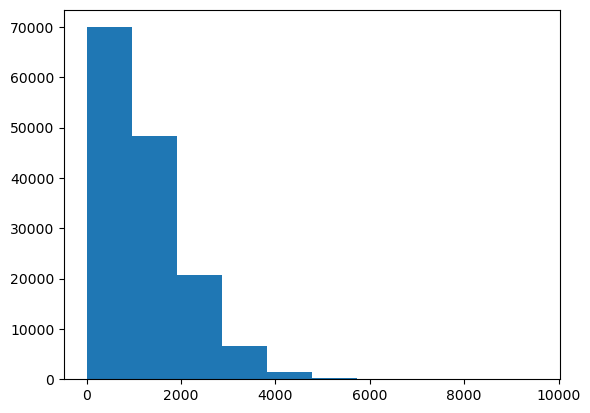

In [55]:
num_timesteps = []
for msn, some_df in flight_dfs.items():
    r, c = some_df.shape
    num_timesteps.append(r)

plt.figure()
plt.hist(np.array(num_timesteps))

In [51]:
grouped = flight_dfs.groupby('fltKey')
flight_dfs = {fltKey: group.sort_values(by=['Time'], ascending=True) for fltKey, group in grouped}

In [52]:
flight_dfs

{34088:            fltKey  CID  UAID        Time  Latitude  Longitude  Altitude  \
 122938699   34088  NaN  2021  1716007989  48.74302  -91.34878      80.0   
 122938700   34088  NaN  2021  1716008001  48.73877  -91.33446      84.0   
 122938701   34088  NaN  2021  1716008013  48.73531  -91.32056      87.0   
 122938702   34088  NaN  2021  1716008025  48.73140  -91.30533      90.0   
 122938703   34088  NaN  2021  1716008037  48.72654  -91.29059      93.0   
 122938704   34088  NaN  2021  1716008049  48.72224  -91.27403      95.0   
 122938705   34088  NaN  2021  1716008061  48.71916  -91.25733      97.0   
 122938706   34088  NaN  2021  1716008073  48.71601  -91.24183      99.0   
 122938707   34088  NaN  2021  1716008085  48.71319  -91.22501     102.0   
 122938708   34088  NaN  2021  1716008097  48.71089  -91.20834     104.0   
 122938709   34088  NaN  2021  1716008109  48.70706  -91.19104     107.0   
 122938710   34088  NaN  2021  1716008121  48.70376  -91.17399     111.0   
 1229

In [ ]:
sample_df = flight_dfs[

In [21]:
dir_clean_iff = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/"
iff_csvs_path_list = glob.glob(dir_clean_iff + "*.csv")

In [46]:
%timeit pd.read_csv(iff_csvs_path_list[0])

<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
<magic-timeit>:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.


24.1 s ± 162 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [49]:
%timeit dd.read_csv(iff_csvs_path_list[0])

ImportError: An error occurred while calling the read_csv method registered to the pandas backend.
Original Message: pyarrow>=10.0.1 is required for PyArrow backed StringArray.

In [24]:
df = pd.read_csv(iff_csvs_path_list[0])

/var/folders/3v/j_z4lh492653rkrwnbw6_p6w0000gn/T/ipykernel_38727/484390228.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(iff_csvs_path_list[0])


In [26]:
df

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,39141,939,UAL1580,1715820655,41.98222,-87.90462,6.5,0xE02,1,0,0,331
1,39141,939,UAL1580,1715820686,41.98226,-87.90465,6.5,0xE02,1,0,0,331
2,39141,939,UAL1580,1715820796,41.98223,-87.90468,6.5,0xE02,1,1,0,217
3,39141,939,UAL1580,1715820835,41.98226,-87.90466,6.5,0xE02,1,1,0,26
4,39141,939,UAL1580,1715820865,41.98226,-87.90465,6.5,0xE02,1,1,0,87
...,...,...,...,...,...,...,...,...,...,...,...,...
62171424,228146,NaN,4352,1715921538,32.47647,-113.09472,127.0,AIG200,1,1,566,139
62171425,228146,NaN,4352,1715921543,32.46517,-113.08875,129.0,AIG200,1,7,541,156
62171426,228146,NaN,4352,1715921553,32.44056,-113.08214,132.0,AIG200,1,10,549,167
62171427,228146,NaN,4352,1715921558,32.42956,-113.07917,132.0,AIG200,1,1,491,167


In [ ]:
# (diff) Time , Latitude	Longitude	Altitude   GroundSpeed   FlightCourse

In [12]:
base_filename = list(files_dict.keys())[0]

In [7]:
# Group csv files by name
dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
files_dict = group_files_by_type(dir_csv)

# A pair of Example files
base_filename = list(files_dict.keys())[0]
d = files_dict[base_filename]
filepath_iff = d["IFF"]
filepath_rd = d["RD"]

iff_dataframe = read_iff(filepath_iff)

100%|█████████████████████████████████████████████████████████████████████████| 52134495/52134495 [01:06<00:00, 784620.92it/s]


converting to dataframe...


In [9]:
iff_dataframe.shape

(50637584, 12)

In [13]:
iff_clean_files_dir = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_clean_iff/"

iff_dataframe.to_csv(iff_clean_files_dir + "clean_" + base_filename + ".csv", index=None, header=True)

In [151]:
# TODO, think about desgin aspects with different options as far as how to approach
# Design aspect 1: load in all csvs in the init ...or... load in csvs dynamically in the iter call
# Design aspect 2: split dataframe by flight mission in init ...or... split by flight mission dynamically in iter call
# Design aspect 3: how to best split into train / val sets 

def read_csvs_compose_flight_dictionary(dict_csvs_grouped):
    """
    Given default dict of csv filepaths grouped by date, read in files and create dictionary of dataframes by flight
    """
    num_iff_files = len(list(dict_csvs_grouped.keys()))
    dict_all_flight_dfs = {}
    for idx_filename, (key, files_dict) in enumerate(dict_csvs_grouped.items()):
        # for now just read in the IFF file (flight path / timestamps) 
        print(f"Reading in file {key} | {idx_filename} / {num_iff_files}")
        filepath_iff = files_dict["IFF"]
        iff_dataframe = read_iff(filepath_iff)

        grouped = iff_dataframe.groupby('fltKey')
        print("grouping by flights") 
        dfs = {fltKey: group.sort_values(by['Time'], ascending=True) for fltKey, group in grouped}
        dict_all_flight_dfs = dict_all_flight_dfs | dfs

    return dict_all_flight_dfs
    
class flight_data_itterator():
    """
    Itterator to get a flight path based on filters / conditions
    """
    def __init__(self, dir_csvs):
        self.dir_csvs = dir_csvs
        self.file_grouping_default_dict = group_files_by_type(dir_csvs)
        
        

In [152]:
dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
dict_csvs_grouped = group_files_by_type(dir_csv)

dict_flights = read_csvs_compose_flight_dictionary(dict_csvs_grouped)

Reading in file USA_20240518_050003_86395_LADDfiltered | 0 / 3


100%|█████████████████████████████████████████████████████████████████████████| 52134495/52134495 [01:26<00:00, 600504.99it/s]


NameError: name 'dtype' is not defined

In [198]:
dict_flights

NameError: name 'dict_flights' is not defined

In [199]:
dir_csv = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
files_dict = group_files_by_type(dir_csv)
files_dict

defaultdict(<function __main__.group_files_by_type.<locals>.<lambda>()>,
            {'USA_20240518_050003_86395_LADDfiltered': {'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv',
              'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240518_050003_86395_LADDfiltered.csv',
              'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240518_050003_86395_LADDfiltered.csv'},
             'USA_20240517_050002_86397_LADDfiltered': {'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240517_050002_86397_LADDfiltered.csv',
              'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240517_050002_86397_LADDfiltered.csv',
              'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240517_050002_86397_LADDfiltered.csv'},
             'USA_20240516_

In [102]:
# A pair of Example files
d = files_dict[list(files_dict.keys())[0]]
filepath_iff = d["IFF"]
filepath_rd = d["RD"]

In [103]:
rd_dataframe = pd.read_csv(filepath_rd, usecols=["Msn", "Orig", "EstOrig", "Dest", "EstDest"])
rd_dataframe

,Msn,Orig,EstOrig,Dest,EstDest
0,34088,?,?,?,?
1,34104,?,?,?,?
2,34115,?,?,?,?
3,34212,?,?,?,OUN
4,34235,?,?,?,ANE
...,...,...,...,...,...
65409,174857,?,?,?,?
65410,174882,RFD,?,unassigned,?
65411,175378,KSFF,SFF,KRNT,RNT
65412,175395,KBUR,BUR,KLAS,LAS


In [104]:
iff_dataframe = read_iff(filepath_iff)

before tqdm


  0%|                                                                            | 65597/52134495 [00:00<01:19, 655964.37it/s]

before for loop


100%|█████████████████████████████████████████████████████████████████████████| 52134495/52134495 [01:08<00:00, 760512.18it/s]


out of for loop
afte close
after tqdm
after convert dict to dataframe


In [105]:
iff_dataframe

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
0,34088,,2021,1716007989,48.74302,-91.34878,80.0,AIG200,1,1,187,114
1,34088,,2021,1716008001,48.73877,-91.33446,84.0,AIG200,1,2,187,114
2,34088,,2021,1716008013,48.73531,-91.32056,87.0,AIG200,1,6,177,111
3,34088,,2021,1716008025,48.73140,-91.30533,90.0,AIG200,1,2,195,111
4,34088,,2021,1716008037,48.72654,-91.29059,93.0,AIG200,1,4,197,117
...,...,...,...,...,...,...,...,...,...,...,...,...
50637579,175599,,4733,1716078224,33.04089,-116.92647,17.0,AIG200,1,1,78,284
50637580,175599,,4733,1716078229,33.04133,-116.92839,17.0,AIG200,1,10,81,285
50637581,175599,,4733,1716078234,33.04172,-116.93042,18.0,AIG200,1,8,77,283
50637582,175599,,4733,1716078239,33.04214,-116.93267,18.0,AIG200,1,10,77,283


In [125]:
iff_dataframe['fltKey'].unique()

array(['34088', '34104', '34115', ..., '175378', '175395', '175599'],
      dtype=object)

In [137]:
grouped = iff_dataframe.groupby('fltKey')
dfs = {fltKey: group for fltKey, group in grouped}

In [141]:
break_idx = 400
for idx, (key, val) in enumerate(dfs.items()):
    print(key, val.shape)
    if idx > break_idx:
        break

100000 (1693, 12)
100001 (234, 12)
100002 (99, 12)
100003 (221, 12)
100004 (165, 12)
100005 (903, 12)
100006 (163, 12)
100007 (387, 12)
100008 (1274, 12)
100009 (195, 12)
100010 (70, 12)
100011 (173, 12)
100012 (1089, 12)
100013 (408, 12)
100014 (452, 12)
100015 (144, 12)
100016 (363, 12)
100017 (1202, 12)
100018 (25, 12)
100019 (862, 12)
100020 (1030, 12)
100021 (2219, 12)
100022 (1590, 12)
100023 (1325, 12)
100024 (20, 12)
100025 (560, 12)
100026 (1554, 12)
100027 (255, 12)
100028 (98, 12)
100029 (678, 12)
100030 (139, 12)
100031 (378, 12)
100032 (345, 12)
100033 (998, 12)
100034 (1222, 12)
100035 (1113, 12)
100036 (794, 12)
100037 (100, 12)
100038 (227, 12)
100039 (305, 12)
100040 (1076, 12)
100041 (1210, 12)
100042 (837, 12)
100043 (878, 12)
100044 (784, 12)
100045 (731, 12)
100046 (637, 12)
100047 (533, 12)
100048 (1297, 12)
100049 (343, 12)
100050 (782, 12)
100051 (1296, 12)
100052 (328, 12)
100053 (149, 12)
100054 (62, 12)
100055 (238, 12)
100056 (776, 12)
100057 (582, 12)
10005

In [144]:
val

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
23062395,100401,,X941TH,1716050729,35.53047,-97.64920,16.0,AIG200,1,1,69,183
23062396,100401,,X941TH,1716050733,35.52917,-97.64928,17.0,AIG200,1,1,69,183
23062397,100401,,X941TH,1716050736,35.52845,-97.64928,17.0,AIG200,1,10,74,180
23062398,100401,,X941TH,1716050741,35.52669,-97.64936,18.0,AIG200,1,1,70,182
23062399,100401,,X941TH,1716050745,35.52551,-97.64944,18.0,AIG200,1,10,66,183
...,...,...,...,...,...,...,...,...,...,...,...,...
23064143,100401,,X941TH,1716058502,35.55081,-97.64554,15.0,AIG200,1,10,82,180
23064144,100401,,X941TH,1716058508,35.54853,-97.64554,14.0,AIG200,1,1,79,180
23064145,100401,,X941TH,1716058513,35.54671,-97.64546,14.0,AIG200,1,10,72,178
23064146,100401,,X941TH,1716058517,35.54547,-97.64554,14.0,AIG200,1,10,65,183


In [142]:
dfs["100362"]

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
23038175,100362,,N0RT,1716054490,34.20006,-118.48803,11.0,AIG200,1,1,100,178
23038176,100362,,N0RT,1716054497,34.19686,-118.48789,12.0,AIG200,1,4,100,178
23038177,100362,,N0RT,1716054500,34.19558,-118.48769,12.0,AIG200,1,10,99,173
23038178,100362,,N0RT,1716054505,34.19336,-118.48736,12.0,AIG200,1,10,107,173
23038179,100362,,N0RT,1716054509,34.19139,-118.48717,13.0,AIG200,1,10,106,175
...,...,...,...,...,...,...,...,...,...,...,...,...
23039198,100362,,N0RT,1716059074,34.22536,-118.48908,12.0,AIG200,1,8,81,193
23039199,100362,,N0RT,1716059078,34.22386,-118.48953,11.0,AIG200,1,1,78,194
23039200,100362,,N0RT,1716059083,34.22214,-118.48989,11.0,AIG200,1,10,80,190
23039201,100362,,N0RT,1716059088,34.22044,-118.49011,10.0,AIG200,1,7,78,186


In [126]:
filtKey = '175378'
filtered_df = iff_dataframe.loc[iff_dataframe['fltKey'] == filtKey]
filtered_df = filtered_df.sort_values(by=['Time'], ascending=True)
filtered_df

,fltKey,CID,UAID,Time,Latitude,Longitude,Altitude,PointSource,RecTypeCat,Significance,GroundSpeed,FlightCourse
50635284,175378,997,N3818C,1716076353,47.67730,-117.33502,21.00,AIG200,1,1,126,232
50635285,175378,997,N3818C,1716076356,47.67627,-117.33696,22.00,AIG200,1,10,126,232
50635286,175378,997,N3818C,1716076362,47.67419,-117.34053,24.00,AIG200,1,1,123,229
50635287,175378,997,N3818C,1716076364,47.67309,-117.34207,25.00,AIG200,1,2,116,223
50635288,175378,997,N3818C,1716076369,47.67120,-117.34391,26.00,AIG200,1,10,120,213
...,...,...,...,...,...,...,...,...,...,...,...,...
50636153,175378,997,N3818C,1716080202,47.47627,-122.21325,2.88,0xE02,1,10,111,354
50636154,175378,997,N3818C,1716080203,47.47678,-122.21332,2.75,0xE02,1,10,111,355
50636155,175378,997,N3818C,1716080204,47.47725,-122.21341,2.63,0xE02,1,10,103,353
50636156,175378,997,N3818C,1716080205,47.47777,-122.21348,2.50,0xE02,1,10,113,355


In [131]:
import sys
sys.getsizeof(filtered_df)

403486

In [133]:
# Latitude is specified in degrees within the range [-90, 90]. 
# Longitude is specified in degrees within the range [-180, 180).

In [120]:
filtered_df.dtypes

fltKey           object
CID              object
UAID             object
Time              int64
Latitude        float64
Longitude       float64
Altitude        float64
PointSource      object
RecTypeCat       object
Significance     object
GroundSpeed      object
FlightCourse     object
dtype: object

In [106]:
iff_dataframe.columns

Index(['fltKey', 'CID', 'UAID', 'Time', 'Latitude', 'Longitude', 'Altitude',
       'PointSource', 'RecTypeCat', 'Significance', 'GroundSpeed',
       'FlightCourse'],
      dtype='object')

In [107]:
iff_dataframe.describe()

,Time,Latitude,Longitude,Altitude
count,5.063758e+07,5.063758e+07,5.063758e+07,5.063758e+07
mean,1.716056e+09,3.670029e+01,-9.420675e+01,1.224281e+02
std,2.044935e+04,5.826378e+00,1.682891e+01,1.346714e+02
min,1.715784e+09,1.401889e+01,-1.586481e+02,0.000000e+00
25%,1.716043e+09,3.304056e+01,-1.061722e+02,9.630000e+00
50%,1.716057e+09,3.699722e+01,-8.991861e+01,5.500000e+01
75%,1.716071e+09,4.077600e+01,-8.096044e+01,2.300000e+02
max,1.716095e+09,6.861013e+01,-6.001583e+01,8.470000e+02


In [108]:
for col in list(iff_dataframe.columns):
    unique_vals = iff_dataframe[col].unique()
    print(col, unique_vals[:10])

fltKey ['34088' '34104' '34115' '34212' '34235' '34278' '34307' '35332' '35391'
 '35405']
CID ['' '170' '533' '780' '953' '329' '829' '077' '118' '240']
UAID ['2021' '1751' '4262' '0450' '0353' 'DAZ10' '1326' 'N524AG' 'SKW3847'
 'DAL660']
Time [1716007989 1716008001 1716008013 1716008025 1716008037 1716008049
 1716008061 1716008073 1716008085 1716008097]
Latitude [48.74302 48.73877 48.73531 48.7314  48.72654 48.72224 48.71916 48.71601
 48.71319 48.71089]
Longitude [-91.34878 -91.33446 -91.32056 -91.30533 -91.29059 -91.27403 -91.25733
 -91.24183 -91.22501 -91.20834]
Altitude [ 80.  84.  87.  90.  93.  95.  97.  99. 102. 104.]
PointSource ['AIG200' 'TH_FIXM' '0xE02']
RecTypeCat ['1']
Significance ['1' '2' '6' '4' '9' '8' '7' '3' '10' '5']
GroundSpeed ['187' '177' '195' '197' '213' '207' '193' '203' '218' '211']
FlightCourse ['114' '111' '117' '106' '107' '104' '102' '109' '100' '103']


In [114]:
iff_dataframe.dtypes

fltKey           object
CID              object
UAID             object
Time              int64
Latitude        float64
Longitude       float64
Altitude        float64
PointSource      object
RecTypeCat       object
Significance     object
GroundSpeed      object
FlightCourse     object
dtype: object

In [ ]:
for col in list(iff_dataframe.columns):
    unique_vals = iff_dataframe[col].unique()
    isdigit_list = []
    not_digit_list = []
    for val in unique_vals:
        if not isinstance(val, str):
            continue
            
        if val.replace(".", "").isdigit():
            isdigit_list.append(val)
        else:
            not_digit_list.append(val)

    print(col)
    print("digit: ", isdigit_list[:10])
    print("not digit: ", not_digit_list[:10])
    print("\n")

In [ ]:
isinstance("abc", str)

In [87]:
float

float

In [91]:
test_dict = {'a': [1, 2, 3.1, 4.2], 'b': ['aa', 'bb', 'cc', 'dd']}
columns = ['a', 'b']
test_dtype = {'a': 'float', 'b': 'string'}
pd.DataFrame(test_dict, 
             columns=columns, 
             dtype=test_dtype)

ValueError: entry not a 2- or 3- tuple

In [26]:
"10".isdigit(), "10.0012".isdigit()

(True, False)

In [30]:
s = "10.002"
s.replace(".", "").isdigit()

True

In [14]:
num_lines = sum(1 for _ in open(filepath_iff))
num_lines

52134495

In [7]:
f = open(filepath_iff)

In [11]:
help(f.readlines)

Help on built-in function readlines:

readlines(hint=-1, /) method of _io.TextIOWrapper instance
    Return a list of lines from the stream.

    hint can be specified to control the number of lines read: no more
    lines will be read if the total size (in bytes/characters) of all
    lines so far exceeds hint.



In [89]:
iff_pd = pd.read_csv(file_iff)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 4, saw 16


In [22]:
dir_gz = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
csv_file_paths = unzip_gzip_util(dir_gz, unzip_here_path = None)

In [24]:
csv_file_paths

['IFF_USA_20240516_050000_86396_LADDfiltered.csv',
 'EV_USA_20240518_050003_86395_LADDfiltered.csv',
 'RD_USA_20240517_050002_86397_LADDfiltered.csv',
 'IFF_USA_20240518_050003_86395_LADDfiltered.csv',
 'EV_USA_20240516_050000_86396_LADDfiltered.csv',
 'EV_USA_20240517_050002_86397_LADDfiltered.csv',
 'RD_USA_20240516_050000_86396_LADDfiltered.csv',
 'RD_USA_20240518_050003_86395_LADDfiltered 2.csv',
 'IFF_USA_20240517_050002_86397_LADDfiltered.csv',
 'RD_USA_20240518_050003_86395_LADDfiltered.csv']

In [72]:
csv_folder_path = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'

d = group_files_by_type(csv_folder_path)
d.keys()

dict_keys(['USA_20240518_050003_86395_LADDfiltered', 'USA_20240517_050002_86397_LADDfiltered', 'USA_20240516_050000_86396_LADDfiltered'])

In [73]:
d['USA_20240518_050003_86395_LADDfiltered']

{'IFF': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv',
 'EV': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240518_050003_86395_LADDfiltered.csv',
 'RD': '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240518_050003_86395_LADDfiltered.csv'}

In [50]:
glob.glob(csv_folder_path + "*.csv")

['/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240517_050002_86397_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240518_050003_86395_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240516_050000_86396_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240517_050002_86397_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240517_050002_86397_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240516_050000_86396_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240518_050003_86395_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/R

In [35]:

files = glob.glob(dir_gz + "IFF*.csv")
files

['/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240517_050002_86397_LADDfiltered.csv',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240516_050000_86396_LADDfiltered.csv']

In [38]:
os.path.basename(files[0]).split(".")[0]

'IFF_USA_20240518_050003_86395_LADDfiltered'

In [39]:
str(Path(files[0]).parent)

'/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz'

In [23]:
dir_gz = '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/'
glob.glob(dir_gz + '*.gz')

['/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240516_050000_86396_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240518_050003_86395_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240517_050002_86397_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/IFF_USA_20240518_050003_86395_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240516_050000_86396_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/EV_USA_20240517_050002_86397_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240516_050000_86396_LADDfiltered.csv.gz',
 '/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/data_gz/RD_USA_20240518_050003_86395_LADDfiltered 2.csv.gz',
 '/Users/aleksandranikevich/Desktop/Aircraft

In [ ]:
from pathlib import Path
p = Path(r'C:\Program Files\Internet Explorer\iexplore.exe')
print(p.parent) 

In [5]:
dir_data = "/Users/aleksandranikevich/Desktop/AircraftTrajectory/data/"
os.listdir(dir_data)

['.DS_Store', 'IFF_USA_20240515_050002_86397_LADDfiltered.csv']

In [4]:
filename = 'IFF_USA_20240515_050002_86397_LADDfiltered.csv'

In [9]:
f = pd.read_csv(dir_data + filename)

ParserError: Error tokenizing data. C error: Expected 4 fields in line 4, saw 16


In [112]:
# ORIGINAL READING IN CODE FROM NASA (Yuck) : 

In [113]:
import pandas
import gzip



# these are variable names for the files (replace with your own) that you may want to parse --> both rd and iff files
iffFileName = 'IFF_USA_20230608_050003_86395.csv'
rdFileName = 'RD_USA_20230608_050003_86395.csv'


# This is a function to read the rd file (includes origin and destination inputs). This also returns
# a list of flight keys that satisfy the origin and destination parameters.
def readRdFile():
    # if you want more fields, add them to usecols as you need to, optional addendums are: AcId,
    # AcType, PC, WC, Airline, CT
    result = pandas.read_csv(rdFileName, usecols=["Msn", "Orig", "EstOrig", "Dest", "EstDest"])
    orig = input("Enter an origin: ")
    dest = input("Enter a destination: ")
    # Uncomment the below lines as you choose which additional fields you want to filter by
    # AcId = input("Enter an AcID: ")
    # AcType = input("Enter an AcType: ")
    # PC = input("Enter a PC: ")
    # WC = input("Enter a WC: ")
    # Airline = input("Enter an Airline: ")
    # CT = input("Enter a CT: ")
    msnVals = []
    for i in range(result['Msn'].size):
        # if we want to make it so that we have more filters from above, just add these lines to the if statement:
        # and result["AcId"][i] == AcId
        # and result["AcType"][i] == AcType
        # and result["PC"][i] == PC
        # and result["WC"][i] == WC
        # and result["Airline"][i] == Airline
        # and result["CT"][i] == CT
        if (result["EstOrig"][i] == orig or result["Orig"][i] == orig) and \
                (result["EstDest"][i] == dest or result["Dest"][i] == dest):
            msnVals.append(result['Msn'][i])
    return msnVals


# This function takes the flight key list from the previous rd function, and then reads every line of the iff file.
# It then only populates a new data frame with data that is flight record type 3 (track points) and where the flight
# key is in the key list. We then export that data frame to a new csv file called merge_clean.
def getMergedCsvFile(flightKeys):
    dictToTurnIntoDataFrame = {'fltKey': [], 'CID': [], 'UAID': [], 'PointSource': [], 'Time': [], 'Latitude': [],
                               'Longitude': [], 'Altitude': [], 'RecTypeCat': [], 'Significance': [],
                               'GroundSpeed': [], 'FlightCourse': []}
    # iffFile = gzip.open(iffFileName, mode='rt')
    iffFile = open(iffFileName)

    while 1:
        lines = iffFile.readlines(50000)
        if not lines:
            break
        for line in lines:
            iffWrite = line.split(",")
            # if you want to filter with significance as well, just add this to the back of the if statement:
            # and iffWrite[12] < 6
            if iffWrite[0] == "3" and int(iffWrite[2]) in flightKeys:  # record type 3 in iff documentation and matching flight
                # key with msn from rd file
                # if iffWrite[2] in flightKeys:
                dictToTurnIntoDataFrame['fltKey'].append(iffWrite[2])
                dictToTurnIntoDataFrame['CID'].append(iffWrite[4])
                dictToTurnIntoDataFrame['UAID'].append(iffWrite[7])
                dictToTurnIntoDataFrame['PointSource'].append(iffWrite[6])
                dictToTurnIntoDataFrame['Time'].append(int(float(iffWrite[1])))
                dictToTurnIntoDataFrame['Latitude'].append(float(iffWrite[9]))
                dictToTurnIntoDataFrame['Longitude'].append(float(iffWrite[10]))
                dictToTurnIntoDataFrame['Altitude'].append(float(iffWrite[11]))
                dictToTurnIntoDataFrame['RecTypeCat'].append(iffWrite[8])
                dictToTurnIntoDataFrame['Significance'].append(iffWrite[12])
                dictToTurnIntoDataFrame['GroundSpeed'].append(iffWrite[16])
                dictToTurnIntoDataFrame['FlightCourse'].append(iffWrite[17])
    iffFile.close()

    #df = dd.DataFrame(dictToTurnIntoDataFrame)
    df = pandas.DataFrame(dictToTurnIntoDataFrame, columns=['fltKey', 'CID', 'UAID', 'Time', 'Latitude', 'Longitude',
                                                            'Altitude', 'PointSource', 'RecTypeCat', 'Significance',
                                                            'GroundSpeed', 'FlightCourse'])
    df.to_csv(r'merge_clean.csv', index=None, header=True)


# These are the commands that need to be run for the functions (serves as the main module)
# msnVals = readRdFile()
# getMergedCsvFile(msnVals)







In [130]:
# According to Bing the readlines(50000) method originaly writen by NASA is indeed not prefereable

"""
You’re correct in your understanding. Using for line in f is generally more memory efficient and simpler than reading chunks of lines with readlines(50000).
Here’s a breakdown:
Memory Efficiency:
for line in f: This approach reads one line at a time, which is very memory efficient, especially for large files. It doesn’t load the entire file into memory.
readlines(50000): This method reads 50,000 lines at a time into memory, which can be less efficient if the file is very large. It can lead to higher memory usage compared to reading one line at a time.
Speed:
for line in f: This is generally fast and straightforward. Python’s file object is an iterator, so it handles the reading efficiently.
readlines(50000): While it might seem like reading in chunks could be faster, the overhead of managing these chunks can negate any potential speed benefits. Additionally, if the file isn’t very large, the difference in speed might be negligible.
Code Simplicity:
for line in f: This method leads to simpler and more readable code. It’s easier to understand and maintain.
readlines(50000): This approach adds complexity without significant benefits in most cases.
In summary, using for line in f is typically the better approach for both memory efficiency and simplicity123. The readlines(50000) method might be useful in very specific scenarios where you need to process large chunks of lines at once, but for most use cases, the simpler method is preferable.
"""

'\nYou’re correct in your understanding. Using for line in f is generally more memory efficient and simpler than reading chunks of lines with readlines(50000).\nHere’s a breakdown:\nMemory Efficiency:\nfor line in f: This approach reads one line at a time, which is very memory efficient, especially for large files. It doesn’t load the entire file into memory.\nreadlines(50000): This method reads 50,000 lines at a time into memory, which can be less efficient if the file is very large. It can lead to higher memory usage compared to reading one line at a time.\nSpeed:\nfor line in f: This is generally fast and straightforward. Python’s file object is an iterator, so it handles the reading efficiently.\nreadlines(50000): While it might seem like reading in chunks could be faster, the overhead of managing these chunks can negate any potential speed benefits. Additionally, if the file isn’t very large, the difference in speed might be negligible.\nCode Simplicity:\nfor line in f: This metho